In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions as f
import os
import sys
%matplotlib inline

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv("data/EURUSD_daily.csv", index_col='Date')
data.index = pd.to_datetime(data.index)
data.columns = ['close', 'open', 'high', 'low', 'pct']
data.drop('pct', axis=1, inplace=True)
data.sort_index(inplace=True)

In [3]:
# add log returns and moving average
data['ret']  = np.log(data.close) - np.log(data.close.shift(1))
data['ma5']  = data.ret.rolling(5).mean()
data['ma20'] = data.ret.rolling(20).mean()

In [4]:
f.adf_test(data['ma20'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.365157339
p-value : 2.34072490034e-18
#Lags Used : 32
Number of Observations Used : 4618
Data is stationary


In [5]:
# remove unstationarity from data
data.close = data.close - data.close.shift(1)
data.open = data.open - data.open.shift(1)
data.high = data.high - data.high.shift(1)
data.low = data.low - data.low.shift(1)

In [6]:
f.adf_test(data['low'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -46.3149070732
p-value : 0.0
#Lags Used : 1
Number of Observations Used : 4668
Data is stationary


In [7]:
data.dropna(inplace=True)

In [8]:
data_description = data.describe()

In [9]:
for col in data.columns:
    data[col] = f.normalize(data[col])

In [10]:
split = pd.Timestamp('01-01-2015')

In [11]:
train = data.loc[:split,]
test = data.loc[split:,]

In [12]:
for col in data.columns:
    train.loc[:,col], test.loc[:,col] = f.scale(train.loc[:,col], test.loc[:,col])

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [13]:
x_train = train[:-1]
y_train = train.ma5.shift(-1)
y_train.dropna(inplace=True)

x_test = test[:-1]
y_test = test.ma5.shift(-1)
y_test.dropna(inplace=True)

In [15]:
x_train.count()

close    3893
open     3893
high     3893
low      3893
ret      3893
ma5      3893
ma20     3893
dtype: int64

In [17]:
x_test.count()

close    757
open     757
high     757
low      757
ret      757
ma5      757
ma20     757
dtype: int64

### Training model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [32]:
batch_size = 32
epochs = 10000
validation_split = 0.05

In [33]:
x_train_np = x_train.values
y_train_np = y_train.values

x_test_np = x_test.values
y_test_np = y_test.values

In [34]:
x_train_t = x_train_np.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test_t = x_test_np.reshape(x_test.shape[0], 1, x_test.shape[1])

In [35]:
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [36]:
K.clear_session()

model = Sequential()

model.add(LSTM(100, input_shape= (x_train_t.shape[1], x_train_t.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            43200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 193,951
Trainable params: 193,951
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(
    x_train_t,
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1, 
#    callbacks=[early_stop], 
    validation_split=validation_split)

Train on 3698 samples, validate on 195 samples
Epoch 1/10000
3698/3698 [==============================] - 0s - loss: 0.3661 - acc: 0.0000e+00 - mean_absolute_error: 0.3661 - val_loss: 0.2163 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2163
Epoch 2/10000
3698/3698 [==============================] - 0s - loss: 0.2979 - acc: 0.0000e+00 - mean_absolute_error: 0.2979 - val_loss: 0.2075 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2075
Epoch 3/10000
3698/3698 [==============================] - 0s - loss: 0.2965 - acc: 0.0000e+00 - mean_absolute_error: 0.2965 - val_loss: 0.2088 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2088
Epoch 4/10000
3698/3698 [==============================] - 0s - loss: 0.2957 - acc: 0.0000e+00 - mean_absolute_error: 0.2957 - val_loss: 0.2123 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2123
Epoch 5/10000
3698/3698 [==============================] - 0s - loss: 0.2960 - acc: 0.0000e+00 - mean_absolute_error: 0.2960 - val_loss: 0.2078 - val_acc

3698/3698 [==============================] - 0s - loss: 0.2897 - acc: 0.0000e+00 - mean_absolute_error: 0.2897 - val_loss: 0.2110 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2110
Epoch 42/10000
3698/3698 [==============================] - 0s - loss: 0.2905 - acc: 0.0000e+00 - mean_absolute_error: 0.2905 - val_loss: 0.2130 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2130
Epoch 43/10000
3698/3698 [==============================] - 0s - loss: 0.2901 - acc: 0.0000e+00 - mean_absolute_error: 0.2901 - val_loss: 0.2102 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2102
Epoch 44/10000
3698/3698 [==============================] - 0s - loss: 0.2905 - acc: 0.0000e+00 - mean_absolute_error: 0.2905 - val_loss: 0.2092 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2092
Epoch 45/10000
3698/3698 [==============================] - 0s - loss: 0.2891 - acc: 0.0000e+00 - mean_absolute_error: 0.2891 - val_loss: 0.2106 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2106
Epoch 46/1

3698/3698 [==============================] - 0s - loss: 0.2878 - acc: 0.0000e+00 - mean_absolute_error: 0.2878 - val_loss: 0.2135 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2135
Epoch 82/10000
3698/3698 [==============================] - 0s - loss: 0.2871 - acc: 0.0000e+00 - mean_absolute_error: 0.2871 - val_loss: 0.2095 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2095
Epoch 83/10000
3698/3698 [==============================] - 0s - loss: 0.2876 - acc: 0.0000e+00 - mean_absolute_error: 0.2876 - val_loss: 0.2144 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2144
Epoch 84/10000
3698/3698 [==============================] - 0s - loss: 0.2869 - acc: 0.0000e+00 - mean_absolute_error: 0.2869 - val_loss: 0.2139 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2139
Epoch 85/10000
3698/3698 [==============================] - 0s - loss: 0.2857 - acc: 0.0000e+00 - mean_absolute_error: 0.2857 - val_loss: 0.2090 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2090
Epoch 86/1

3698/3698 [==============================] - 0s - loss: 0.2876 - acc: 0.0000e+00 - mean_absolute_error: 0.2876 - val_loss: 0.2138 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2138
Epoch 122/10000
3698/3698 [==============================] - 0s - loss: 0.2872 - acc: 0.0000e+00 - mean_absolute_error: 0.2872 - val_loss: 0.2108 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2108
Epoch 123/10000
3698/3698 [==============================] - 0s - loss: 0.2864 - acc: 0.0000e+00 - mean_absolute_error: 0.2864 - val_loss: 0.2110 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2110
Epoch 124/10000
3698/3698 [==============================] - 0s - loss: 0.2878 - acc: 0.0000e+00 - mean_absolute_error: 0.2878 - val_loss: 0.2095 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2095
Epoch 125/10000
3698/3698 [==============================] - 0s - loss: 0.2850 - acc: 0.0000e+00 - mean_absolute_error: 0.2850 - val_loss: 0.2088 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2088
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2862 - acc: 0.0000e+00 - mean_absolute_error: 0.2862 - val_loss: 0.2119 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2119
Epoch 162/10000
3698/3698 [==============================] - 0s - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.2858 - val_loss: 0.2095 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2095
Epoch 163/10000
3698/3698 [==============================] - 0s - loss: 0.2858 - acc: 0.0000e+00 - mean_absolute_error: 0.2858 - val_loss: 0.2104 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2104
Epoch 164/10000
3698/3698 [==============================] - 0s - loss: 0.2852 - acc: 0.0000e+00 - mean_absolute_error: 0.2852 - val_loss: 0.2110 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2110
Epoch 165/10000
3698/3698 [==============================] - 0s - loss: 0.2851 - acc: 0.0000e+00 - mean_absolute_error: 0.2851 - val_loss: 0.2145 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2145
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2854 - acc: 0.0000e+00 - mean_absolute_error: 0.2854 - val_loss: 0.2160 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2160
Epoch 202/10000
3698/3698 [==============================] - 0s - loss: 0.2843 - acc: 0.0000e+00 - mean_absolute_error: 0.2843 - val_loss: 0.2129 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2129
Epoch 203/10000
3698/3698 [==============================] - 0s - loss: 0.2848 - acc: 0.0000e+00 - mean_absolute_error: 0.2848 - val_loss: 0.2132 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2132
Epoch 204/10000
3698/3698 [==============================] - 0s - loss: 0.2841 - acc: 0.0000e+00 - mean_absolute_error: 0.2841 - val_loss: 0.2107 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2107
Epoch 205/10000
3698/3698 [==============================] - 0s - loss: 0.2852 - acc: 0.0000e+00 - mean_absolute_error: 0.2852 - val_loss: 0.2103 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2103
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2850 - acc: 0.0000e+00 - mean_absolute_error: 0.2850 - val_loss: 0.2116 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2116
Epoch 242/10000
3698/3698 [==============================] - 0s - loss: 0.2835 - acc: 0.0000e+00 - mean_absolute_error: 0.2835 - val_loss: 0.2113 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2113
Epoch 243/10000
3698/3698 [==============================] - 0s - loss: 0.2845 - acc: 0.0000e+00 - mean_absolute_error: 0.2845 - val_loss: 0.2083 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2083
Epoch 244/10000
3698/3698 [==============================] - 0s - loss: 0.2836 - acc: 0.0000e+00 - mean_absolute_error: 0.2836 - val_loss: 0.2085 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2085
Epoch 245/10000
3698/3698 [==============================] - 0s - loss: 0.2846 - acc: 0.0000e+00 - mean_absolute_error: 0.2846 - val_loss: 0.2123 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2123
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2810 - acc: 0.0000e+00 - mean_absolute_error: 0.2810 - val_loss: 0.2190 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2190
Epoch 282/10000
3698/3698 [==============================] - 0s - loss: 0.2816 - acc: 0.0000e+00 - mean_absolute_error: 0.2816 - val_loss: 0.2103 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2103
Epoch 283/10000
3698/3698 [==============================] - 0s - loss: 0.2815 - acc: 0.0000e+00 - mean_absolute_error: 0.2815 - val_loss: 0.2135 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2135
Epoch 284/10000
3698/3698 [==============================] - 0s - loss: 0.2820 - acc: 0.0000e+00 - mean_absolute_error: 0.2820 - val_loss: 0.2124 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2124
Epoch 285/10000
3698/3698 [==============================] - 0s - loss: 0.2819 - acc: 0.0000e+00 - mean_absolute_error: 0.2819 - val_loss: 0.2114 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2114
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2802 - acc: 0.0000e+00 - mean_absolute_error: 0.2802 - val_loss: 0.2100 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2100
Epoch 322/10000
3698/3698 [==============================] - 0s - loss: 0.2813 - acc: 0.0000e+00 - mean_absolute_error: 0.2813 - val_loss: 0.2094 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2094
Epoch 323/10000
3698/3698 [==============================] - 0s - loss: 0.2808 - acc: 0.0000e+00 - mean_absolute_error: 0.2808 - val_loss: 0.2127 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2127
Epoch 324/10000
3698/3698 [==============================] - 0s - loss: 0.2794 - acc: 0.0000e+00 - mean_absolute_error: 0.2794 - val_loss: 0.2148 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2148
Epoch 325/10000
3698/3698 [==============================] - 0s - loss: 0.2805 - acc: 0.0000e+00 - mean_absolute_error: 0.2805 - val_loss: 0.2129 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2129
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2791 - acc: 0.0000e+00 - mean_absolute_error: 0.2791 - val_loss: 0.2108 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2108
Epoch 362/10000
3698/3698 [==============================] - 0s - loss: 0.2787 - acc: 0.0000e+00 - mean_absolute_error: 0.2787 - val_loss: 0.2143 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2143
Epoch 363/10000
3698/3698 [==============================] - 0s - loss: 0.2793 - acc: 0.0000e+00 - mean_absolute_error: 0.2793 - val_loss: 0.2150 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2150
Epoch 364/10000
3698/3698 [==============================] - 0s - loss: 0.2786 - acc: 0.0000e+00 - mean_absolute_error: 0.2786 - val_loss: 0.2139 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2139
Epoch 365/10000
3698/3698 [==============================] - 0s - loss: 0.2785 - acc: 0.0000e+00 - mean_absolute_error: 0.2785 - val_loss: 0.2127 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2127
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2778 - acc: 0.0000e+00 - mean_absolute_error: 0.2778 - val_loss: 0.2135 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2135
Epoch 402/10000
3698/3698 [==============================] - 0s - loss: 0.2764 - acc: 0.0000e+00 - mean_absolute_error: 0.2764 - val_loss: 0.2159 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2159
Epoch 403/10000
3698/3698 [==============================] - 0s - loss: 0.2773 - acc: 0.0000e+00 - mean_absolute_error: 0.2773 - val_loss: 0.2168 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2168
Epoch 404/10000
3698/3698 [==============================] - 0s - loss: 0.2766 - acc: 0.0000e+00 - mean_absolute_error: 0.2766 - val_loss: 0.2189 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2189
Epoch 405/10000
3698/3698 [==============================] - 0s - loss: 0.2765 - acc: 0.0000e+00 - mean_absolute_error: 0.2765 - val_loss: 0.2168 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2168
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2744 - acc: 0.0000e+00 - mean_absolute_error: 0.2744 - val_loss: 0.2174 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2174
Epoch 442/10000
3698/3698 [==============================] - 0s - loss: 0.2761 - acc: 0.0000e+00 - mean_absolute_error: 0.2761 - val_loss: 0.2151 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2151
Epoch 443/10000
3698/3698 [==============================] - 0s - loss: 0.2762 - acc: 0.0000e+00 - mean_absolute_error: 0.2762 - val_loss: 0.2155 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2155
Epoch 444/10000
3698/3698 [==============================] - 0s - loss: 0.2752 - acc: 0.0000e+00 - mean_absolute_error: 0.2752 - val_loss: 0.2143 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2143
Epoch 445/10000
3698/3698 [==============================] - 0s - loss: 0.2741 - acc: 0.0000e+00 - mean_absolute_error: 0.2741 - val_loss: 0.2201 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2201
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2717 - acc: 0.0000e+00 - mean_absolute_error: 0.2717 - val_loss: 0.2176 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2176
Epoch 482/10000
3698/3698 [==============================] - 0s - loss: 0.2721 - acc: 0.0000e+00 - mean_absolute_error: 0.2721 - val_loss: 0.2171 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2171
Epoch 483/10000
3698/3698 [==============================] - 0s - loss: 0.2718 - acc: 0.0000e+00 - mean_absolute_error: 0.2718 - val_loss: 0.2168 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2168
Epoch 484/10000
3698/3698 [==============================] - 0s - loss: 0.2716 - acc: 0.0000e+00 - mean_absolute_error: 0.2716 - val_loss: 0.2189 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2189
Epoch 485/10000
3698/3698 [==============================] - 0s - loss: 0.2727 - acc: 0.0000e+00 - mean_absolute_error: 0.2727 - val_loss: 0.2172 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2172
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2709 - acc: 0.0000e+00 - mean_absolute_error: 0.2709 - val_loss: 0.2126 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2126
Epoch 522/10000
3698/3698 [==============================] - 0s - loss: 0.2695 - acc: 0.0000e+00 - mean_absolute_error: 0.2695 - val_loss: 0.2165 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2165
Epoch 523/10000
3698/3698 [==============================] - 0s - loss: 0.2686 - acc: 0.0000e+00 - mean_absolute_error: 0.2686 - val_loss: 0.2163 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2163
Epoch 524/10000
3698/3698 [==============================] - 0s - loss: 0.2695 - acc: 0.0000e+00 - mean_absolute_error: 0.2695 - val_loss: 0.2180 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2180
Epoch 525/10000
3698/3698 [==============================] - 0s - loss: 0.2688 - acc: 0.0000e+00 - mean_absolute_error: 0.2688 - val_loss: 0.2184 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2184
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2674 - acc: 0.0000e+00 - mean_absolute_error: 0.2674 - val_loss: 0.2169 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2169
Epoch 562/10000
3698/3698 [==============================] - 0s - loss: 0.2677 - acc: 0.0000e+00 - mean_absolute_error: 0.2677 - val_loss: 0.2162 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2162
Epoch 563/10000
3698/3698 [==============================] - 0s - loss: 0.2667 - acc: 0.0000e+00 - mean_absolute_error: 0.2667 - val_loss: 0.2143 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2143
Epoch 564/10000
3698/3698 [==============================] - 0s - loss: 0.2657 - acc: 0.0000e+00 - mean_absolute_error: 0.2657 - val_loss: 0.2189 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2189
Epoch 565/10000
3698/3698 [==============================] - 0s - loss: 0.2666 - acc: 0.0000e+00 - mean_absolute_error: 0.2666 - val_loss: 0.2159 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2159
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2632 - acc: 0.0000e+00 - mean_absolute_error: 0.2632 - val_loss: 0.2187 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2187
Epoch 602/10000
3698/3698 [==============================] - 0s - loss: 0.2630 - acc: 0.0000e+00 - mean_absolute_error: 0.2630 - val_loss: 0.2162 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2162
Epoch 603/10000
3698/3698 [==============================] - 0s - loss: 0.2631 - acc: 0.0000e+00 - mean_absolute_error: 0.2631 - val_loss: 0.2149 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2149
Epoch 604/10000
3698/3698 [==============================] - 0s - loss: 0.2633 - acc: 0.0000e+00 - mean_absolute_error: 0.2633 - val_loss: 0.2180 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2180
Epoch 605/10000
3698/3698 [==============================] - 0s - loss: 0.2634 - acc: 0.0000e+00 - mean_absolute_error: 0.2634 - val_loss: 0.2212 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2212
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2591 - acc: 0.0000e+00 - mean_absolute_error: 0.2591 - val_loss: 0.2193 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2193
Epoch 642/10000
3698/3698 [==============================] - 0s - loss: 0.2581 - acc: 0.0000e+00 - mean_absolute_error: 0.2581 - val_loss: 0.2222 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2222
Epoch 643/10000
3698/3698 [==============================] - 0s - loss: 0.2608 - acc: 0.0000e+00 - mean_absolute_error: 0.2608 - val_loss: 0.2193 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2193
Epoch 644/10000
3698/3698 [==============================] - 0s - loss: 0.2595 - acc: 0.0000e+00 - mean_absolute_error: 0.2595 - val_loss: 0.2213 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2213
Epoch 645/10000
3698/3698 [==============================] - 0s - loss: 0.2591 - acc: 0.0000e+00 - mean_absolute_error: 0.2591 - val_loss: 0.2176 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2176
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2541 - acc: 0.0000e+00 - mean_absolute_error: 0.2541 - val_loss: 0.2206 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2206
Epoch 682/10000
3698/3698 [==============================] - 0s - loss: 0.2543 - acc: 0.0000e+00 - mean_absolute_error: 0.2543 - val_loss: 0.2223 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2223
Epoch 683/10000
3698/3698 [==============================] - 0s - loss: 0.2564 - acc: 0.0000e+00 - mean_absolute_error: 0.2564 - val_loss: 0.2237 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2237
Epoch 684/10000
3698/3698 [==============================] - 0s - loss: 0.2568 - acc: 0.0000e+00 - mean_absolute_error: 0.2568 - val_loss: 0.2217 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2217
Epoch 685/10000
3698/3698 [==============================] - 0s - loss: 0.2564 - acc: 0.0000e+00 - mean_absolute_error: 0.2564 - val_loss: 0.2219 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2219
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2508 - acc: 0.0000e+00 - mean_absolute_error: 0.2508 - val_loss: 0.2191 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2191
Epoch 722/10000
3698/3698 [==============================] - 0s - loss: 0.2494 - acc: 0.0000e+00 - mean_absolute_error: 0.2494 - val_loss: 0.2196 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2196
Epoch 723/10000
3698/3698 [==============================] - 0s - loss: 0.2529 - acc: 0.0000e+00 - mean_absolute_error: 0.2529 - val_loss: 0.2210 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2210
Epoch 724/10000
3698/3698 [==============================] - 0s - loss: 0.2501 - acc: 0.0000e+00 - mean_absolute_error: 0.2501 - val_loss: 0.2199 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2199
Epoch 725/10000
3698/3698 [==============================] - 0s - loss: 0.2516 - acc: 0.0000e+00 - mean_absolute_error: 0.2516 - val_loss: 0.2233 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2233
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2475 - acc: 0.0000e+00 - mean_absolute_error: 0.2475 - val_loss: 0.2160 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2160
Epoch 762/10000
3698/3698 [==============================] - 0s - loss: 0.2489 - acc: 0.0000e+00 - mean_absolute_error: 0.2489 - val_loss: 0.2188 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2188
Epoch 763/10000
3698/3698 [==============================] - 0s - loss: 0.2449 - acc: 0.0000e+00 - mean_absolute_error: 0.2449 - val_loss: 0.2201 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2201
Epoch 764/10000
3698/3698 [==============================] - 0s - loss: 0.2459 - acc: 0.0000e+00 - mean_absolute_error: 0.2459 - val_loss: 0.2202 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2202
Epoch 765/10000
3698/3698 [==============================] - 0s - loss: 0.2471 - acc: 0.0000e+00 - mean_absolute_error: 0.2471 - val_loss: 0.2237 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2237
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2406 - acc: 0.0000e+00 - mean_absolute_error: 0.2406 - val_loss: 0.2278 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2278
Epoch 802/10000
3698/3698 [==============================] - 0s - loss: 0.2424 - acc: 0.0000e+00 - mean_absolute_error: 0.2424 - val_loss: 0.2295 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2295
Epoch 803/10000
3698/3698 [==============================] - 0s - loss: 0.2430 - acc: 0.0000e+00 - mean_absolute_error: 0.2430 - val_loss: 0.2247 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2247
Epoch 804/10000
3698/3698 [==============================] - 0s - loss: 0.2410 - acc: 0.0000e+00 - mean_absolute_error: 0.2410 - val_loss: 0.2218 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2218
Epoch 805/10000
3698/3698 [==============================] - 0s - loss: 0.2428 - acc: 0.0000e+00 - mean_absolute_error: 0.2428 - val_loss: 0.2257 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2257
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2374 - acc: 0.0000e+00 - mean_absolute_error: 0.2374 - val_loss: 0.2243 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2243
Epoch 842/10000
3698/3698 [==============================] - 0s - loss: 0.2364 - acc: 0.0000e+00 - mean_absolute_error: 0.2364 - val_loss: 0.2189 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2189
Epoch 843/10000
3698/3698 [==============================] - 0s - loss: 0.2376 - acc: 0.0000e+00 - mean_absolute_error: 0.2376 - val_loss: 0.2261 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2261
Epoch 844/10000
3698/3698 [==============================] - 0s - loss: 0.2354 - acc: 0.0000e+00 - mean_absolute_error: 0.2354 - val_loss: 0.2271 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2271
Epoch 845/10000
3698/3698 [==============================] - 0s - loss: 0.2375 - acc: 0.0000e+00 - mean_absolute_error: 0.2375 - val_loss: 0.2290 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2290
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2330 - acc: 0.0000e+00 - mean_absolute_error: 0.2330 - val_loss: 0.2302 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2302
Epoch 882/10000
3698/3698 [==============================] - 0s - loss: 0.2328 - acc: 0.0000e+00 - mean_absolute_error: 0.2328 - val_loss: 0.2322 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2322
Epoch 883/10000
3698/3698 [==============================] - 0s - loss: 0.2337 - acc: 0.0000e+00 - mean_absolute_error: 0.2337 - val_loss: 0.2347 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2347
Epoch 884/10000
3698/3698 [==============================] - 0s - loss: 0.2358 - acc: 0.0000e+00 - mean_absolute_error: 0.2358 - val_loss: 0.2316 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2316
Epoch 885/10000
3698/3698 [==============================] - 0s - loss: 0.2325 - acc: 0.0000e+00 - mean_absolute_error: 0.2325 - val_loss: 0.2333 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2333
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2241 - acc: 0.0000e+00 - mean_absolute_error: 0.2241 - val_loss: 0.2294 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2294
Epoch 922/10000
3698/3698 [==============================] - 0s - loss: 0.2250 - acc: 0.0000e+00 - mean_absolute_error: 0.2250 - val_loss: 0.2310 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2310
Epoch 923/10000
3698/3698 [==============================] - 0s - loss: 0.2300 - acc: 0.0000e+00 - mean_absolute_error: 0.2300 - val_loss: 0.2322 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2322
Epoch 924/10000
3698/3698 [==============================] - 0s - loss: 0.2304 - acc: 0.0000e+00 - mean_absolute_error: 0.2304 - val_loss: 0.2301 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2301
Epoch 925/10000
3698/3698 [==============================] - 0s - loss: 0.2260 - acc: 0.0000e+00 - mean_absolute_error: 0.2260 - val_loss: 0.2297 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2297
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2237 - acc: 0.0000e+00 - mean_absolute_error: 0.2237 - val_loss: 0.2418 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2418
Epoch 962/10000
3698/3698 [==============================] - 0s - loss: 0.2262 - acc: 0.0000e+00 - mean_absolute_error: 0.2262 - val_loss: 0.2381 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2381
Epoch 963/10000
3698/3698 [==============================] - 0s - loss: 0.2233 - acc: 0.0000e+00 - mean_absolute_error: 0.2233 - val_loss: 0.2355 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2355
Epoch 964/10000
3698/3698 [==============================] - 0s - loss: 0.2245 - acc: 0.0000e+00 - mean_absolute_error: 0.2245 - val_loss: 0.2358 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2358
Epoch 965/10000
3698/3698 [==============================] - 0s - loss: 0.2244 - acc: 0.0000e+00 - mean_absolute_error: 0.2244 - val_loss: 0.2380 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2380
Epoch 

3698/3698 [==============================] - 0s - loss: 0.2240 - acc: 0.0000e+00 - mean_absolute_error: 0.2240 - val_loss: 0.2386 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2386
Epoch 1002/10000
3698/3698 [==============================] - 0s - loss: 0.2199 - acc: 0.0000e+00 - mean_absolute_error: 0.2199 - val_loss: 0.2362 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2362
Epoch 1003/10000
3698/3698 [==============================] - 0s - loss: 0.2215 - acc: 0.0000e+00 - mean_absolute_error: 0.2215 - val_loss: 0.2363 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2363
Epoch 1004/10000
3698/3698 [==============================] - 0s - loss: 0.2182 - acc: 0.0000e+00 - mean_absolute_error: 0.2182 - val_loss: 0.2464 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2464
Epoch 1005/10000
3698/3698 [==============================] - 0s - loss: 0.2205 - acc: 0.0000e+00 - mean_absolute_error: 0.2205 - val_loss: 0.2361 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2361
Ep

3698/3698 [==============================] - 0s - loss: 0.2200 - acc: 0.0000e+00 - mean_absolute_error: 0.2200 - val_loss: 0.2369 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2369
Epoch 1042/10000
3698/3698 [==============================] - 0s - loss: 0.2170 - acc: 0.0000e+00 - mean_absolute_error: 0.2170 - val_loss: 0.2382 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2382
Epoch 1043/10000
3698/3698 [==============================] - 0s - loss: 0.2162 - acc: 0.0000e+00 - mean_absolute_error: 0.2162 - val_loss: 0.2375 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2375
Epoch 1044/10000
3698/3698 [==============================] - 0s - loss: 0.2176 - acc: 0.0000e+00 - mean_absolute_error: 0.2176 - val_loss: 0.2351 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2351
Epoch 1045/10000
3698/3698 [==============================] - 0s - loss: 0.2167 - acc: 0.0000e+00 - mean_absolute_error: 0.2167 - val_loss: 0.2393 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2393
Ep

3698/3698 [==============================] - 0s - loss: 0.2130 - acc: 0.0000e+00 - mean_absolute_error: 0.2130 - val_loss: 0.2416 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2416
Epoch 1082/10000
3698/3698 [==============================] - 0s - loss: 0.2157 - acc: 0.0000e+00 - mean_absolute_error: 0.2157 - val_loss: 0.2407 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2407
Epoch 1083/10000
3698/3698 [==============================] - 0s - loss: 0.2142 - acc: 0.0000e+00 - mean_absolute_error: 0.2142 - val_loss: 0.2458 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2458
Epoch 1084/10000
3698/3698 [==============================] - 0s - loss: 0.2138 - acc: 0.0000e+00 - mean_absolute_error: 0.2138 - val_loss: 0.2417 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2417
Epoch 1085/10000
3698/3698 [==============================] - 0s - loss: 0.2173 - acc: 0.0000e+00 - mean_absolute_error: 0.2173 - val_loss: 0.2431 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2431
Ep

3698/3698 [==============================] - 0s - loss: 0.2130 - acc: 0.0000e+00 - mean_absolute_error: 0.2130 - val_loss: 0.2470 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2470
Epoch 1122/10000
3698/3698 [==============================] - 0s - loss: 0.2114 - acc: 0.0000e+00 - mean_absolute_error: 0.2114 - val_loss: 0.2456 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2456
Epoch 1123/10000
3698/3698 [==============================] - 0s - loss: 0.2128 - acc: 0.0000e+00 - mean_absolute_error: 0.2128 - val_loss: 0.2442 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2442
Epoch 1124/10000
3698/3698 [==============================] - 0s - loss: 0.2116 - acc: 0.0000e+00 - mean_absolute_error: 0.2116 - val_loss: 0.2396 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2396
Epoch 1125/10000
3698/3698 [==============================] - 0s - loss: 0.2113 - acc: 0.0000e+00 - mean_absolute_error: 0.2113 - val_loss: 0.2459 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2459
Ep

3698/3698 [==============================] - 0s - loss: 0.2058 - acc: 0.0000e+00 - mean_absolute_error: 0.2058 - val_loss: 0.2457 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2457
Epoch 1162/10000
3698/3698 [==============================] - 0s - loss: 0.2052 - acc: 0.0000e+00 - mean_absolute_error: 0.2052 - val_loss: 0.2479 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2479
Epoch 1163/10000
3698/3698 [==============================] - 0s - loss: 0.2043 - acc: 0.0000e+00 - mean_absolute_error: 0.2043 - val_loss: 0.2508 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2508
Epoch 1164/10000
3698/3698 [==============================] - 0s - loss: 0.2077 - acc: 0.0000e+00 - mean_absolute_error: 0.2077 - val_loss: 0.2481 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2481
Epoch 1165/10000
3698/3698 [==============================] - 0s - loss: 0.2076 - acc: 0.0000e+00 - mean_absolute_error: 0.2076 - val_loss: 0.2432 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2432
Ep

3698/3698 [==============================] - 0s - loss: 0.2025 - acc: 0.0000e+00 - mean_absolute_error: 0.2025 - val_loss: 0.2497 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2497
Epoch 1202/10000
3698/3698 [==============================] - 0s - loss: 0.2052 - acc: 0.0000e+00 - mean_absolute_error: 0.2052 - val_loss: 0.2467 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2467
Epoch 1203/10000
3698/3698 [==============================] - 0s - loss: 0.2052 - acc: 0.0000e+00 - mean_absolute_error: 0.2052 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Epoch 1204/10000
3698/3698 [==============================] - 0s - loss: 0.2038 - acc: 0.0000e+00 - mean_absolute_error: 0.2038 - val_loss: 0.2500 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2500
Epoch 1205/10000
3698/3698 [==============================] - 0s - loss: 0.2063 - acc: 0.0000e+00 - mean_absolute_error: 0.2063 - val_loss: 0.2519 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2519
Ep

3698/3698 [==============================] - 0s - loss: 0.2006 - acc: 0.0000e+00 - mean_absolute_error: 0.2006 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 1242/10000
3698/3698 [==============================] - 0s - loss: 0.2010 - acc: 0.0000e+00 - mean_absolute_error: 0.2010 - val_loss: 0.2505 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2505
Epoch 1243/10000
3698/3698 [==============================] - 0s - loss: 0.2007 - acc: 0.0000e+00 - mean_absolute_error: 0.2007 - val_loss: 0.2497 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2497
Epoch 1244/10000
3698/3698 [==============================] - 0s - loss: 0.1996 - acc: 0.0000e+00 - mean_absolute_error: 0.1996 - val_loss: 0.2496 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2496
Epoch 1245/10000
3698/3698 [==============================] - 0s - loss: 0.2010 - acc: 0.0000e+00 - mean_absolute_error: 0.2010 - val_loss: 0.2474 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2474
Ep

3698/3698 [==============================] - 0s - loss: 0.1999 - acc: 0.0000e+00 - mean_absolute_error: 0.1999 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 1282/10000
3698/3698 [==============================] - 0s - loss: 0.1981 - acc: 0.0000e+00 - mean_absolute_error: 0.1981 - val_loss: 0.2517 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2517
Epoch 1283/10000
3698/3698 [==============================] - 0s - loss: 0.1994 - acc: 0.0000e+00 - mean_absolute_error: 0.1994 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 1284/10000
3698/3698 [==============================] - 0s - loss: 0.1973 - acc: 0.0000e+00 - mean_absolute_error: 0.1973 - val_loss: 0.2515 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2515
Epoch 1285/10000
3698/3698 [==============================] - 0s - loss: 0.1988 - acc: 0.0000e+00 - mean_absolute_error: 0.1988 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Ep

3698/3698 [==============================] - 0s - loss: 0.1968 - acc: 0.0000e+00 - mean_absolute_error: 0.1968 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 1322/10000
3698/3698 [==============================] - 0s - loss: 0.1949 - acc: 0.0000e+00 - mean_absolute_error: 0.1949 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Epoch 1323/10000
3698/3698 [==============================] - 0s - loss: 0.1950 - acc: 0.0000e+00 - mean_absolute_error: 0.1950 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 1324/10000
3698/3698 [==============================] - 0s - loss: 0.1963 - acc: 0.0000e+00 - mean_absolute_error: 0.1963 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 1325/10000
3698/3698 [==============================] - 0s - loss: 0.1943 - acc: 0.0000e+00 - mean_absolute_error: 0.1943 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Ep

3698/3698 [==============================] - 0s - loss: 0.1944 - acc: 0.0000e+00 - mean_absolute_error: 0.1944 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 1362/10000
3698/3698 [==============================] - 0s - loss: 0.1897 - acc: 0.0000e+00 - mean_absolute_error: 0.1897 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 1363/10000
3698/3698 [==============================] - 0s - loss: 0.1957 - acc: 0.0000e+00 - mean_absolute_error: 0.1957 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 1364/10000
3698/3698 [==============================] - 0s - loss: 0.1904 - acc: 0.0000e+00 - mean_absolute_error: 0.1904 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Epoch 1365/10000
3698/3698 [==============================] - 0s - loss: 0.1943 - acc: 0.0000e+00 - mean_absolute_error: 0.1943 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Ep

3698/3698 [==============================] - 0s - loss: 0.1939 - acc: 0.0000e+00 - mean_absolute_error: 0.1939 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 1402/10000
3698/3698 [==============================] - 0s - loss: 0.1936 - acc: 0.0000e+00 - mean_absolute_error: 0.1936 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Epoch 1403/10000
3698/3698 [==============================] - 0s - loss: 0.1926 - acc: 0.0000e+00 - mean_absolute_error: 0.1926 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 1404/10000
3698/3698 [==============================] - 0s - loss: 0.1898 - acc: 0.0000e+00 - mean_absolute_error: 0.1898 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Epoch 1405/10000
3698/3698 [==============================] - 0s - loss: 0.1915 - acc: 0.0000e+00 - mean_absolute_error: 0.1915 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Ep

3698/3698 [==============================] - 0s - loss: 0.1879 - acc: 0.0000e+00 - mean_absolute_error: 0.1879 - val_loss: 0.2659 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2659
Epoch 1442/10000
3698/3698 [==============================] - 0s - loss: 0.1905 - acc: 0.0000e+00 - mean_absolute_error: 0.1905 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 1443/10000
3698/3698 [==============================] - 0s - loss: 0.1888 - acc: 0.0000e+00 - mean_absolute_error: 0.1888 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 1444/10000
3698/3698 [==============================] - 0s - loss: 0.1880 - acc: 0.0000e+00 - mean_absolute_error: 0.1880 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Epoch 1445/10000
3698/3698 [==============================] - 0s - loss: 0.1897 - acc: 0.0000e+00 - mean_absolute_error: 0.1897 - val_loss: 0.2605 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2605
Ep

3698/3698 [==============================] - 0s - loss: 0.1853 - acc: 0.0000e+00 - mean_absolute_error: 0.1853 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 1482/10000
3698/3698 [==============================] - 0s - loss: 0.1847 - acc: 0.0000e+00 - mean_absolute_error: 0.1847 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 1483/10000
3698/3698 [==============================] - 0s - loss: 0.1844 - acc: 0.0000e+00 - mean_absolute_error: 0.1844 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Epoch 1484/10000
3698/3698 [==============================] - 0s - loss: 0.1869 - acc: 0.0000e+00 - mean_absolute_error: 0.1869 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 1485/10000
3698/3698 [==============================] - 0s - loss: 0.1900 - acc: 0.0000e+00 - mean_absolute_error: 0.1900 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Ep

3698/3698 [==============================] - 0s - loss: 0.1820 - acc: 0.0000e+00 - mean_absolute_error: 0.1820 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 1522/10000
3698/3698 [==============================] - 0s - loss: 0.1841 - acc: 0.0000e+00 - mean_absolute_error: 0.1841 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 1523/10000
3698/3698 [==============================] - 0s - loss: 0.1849 - acc: 0.0000e+00 - mean_absolute_error: 0.1849 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 1524/10000
3698/3698 [==============================] - 0s - loss: 0.1873 - acc: 0.0000e+00 - mean_absolute_error: 0.1873 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Epoch 1525/10000
3698/3698 [==============================] - 0s - loss: 0.1849 - acc: 0.0000e+00 - mean_absolute_error: 0.1849 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Ep

3698/3698 [==============================] - 0s - loss: 0.1805 - acc: 0.0000e+00 - mean_absolute_error: 0.1805 - val_loss: 0.2579 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2579
Epoch 1562/10000
3698/3698 [==============================] - 0s - loss: 0.1846 - acc: 0.0000e+00 - mean_absolute_error: 0.1846 - val_loss: 0.2598 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2598
Epoch 1563/10000
3698/3698 [==============================] - 0s - loss: 0.1821 - acc: 0.0000e+00 - mean_absolute_error: 0.1821 - val_loss: 0.2627 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2627
Epoch 1564/10000
3698/3698 [==============================] - 0s - loss: 0.1840 - acc: 0.0000e+00 - mean_absolute_error: 0.1840 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 1565/10000
3698/3698 [==============================] - 0s - loss: 0.1840 - acc: 0.0000e+00 - mean_absolute_error: 0.1840 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Ep

3698/3698 [==============================] - 0s - loss: 0.1816 - acc: 0.0000e+00 - mean_absolute_error: 0.1816 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2636
Epoch 1602/10000
3698/3698 [==============================] - 0s - loss: 0.1807 - acc: 0.0000e+00 - mean_absolute_error: 0.1807 - val_loss: 0.2592 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2592
Epoch 1603/10000
3698/3698 [==============================] - 0s - loss: 0.1829 - acc: 0.0000e+00 - mean_absolute_error: 0.1829 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Epoch 1604/10000
3698/3698 [==============================] - 0s - loss: 0.1840 - acc: 0.0000e+00 - mean_absolute_error: 0.1840 - val_loss: 0.2619 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2619
Epoch 1605/10000
3698/3698 [==============================] - 0s - loss: 0.1807 - acc: 0.0000e+00 - mean_absolute_error: 0.1807 - val_loss: 0.2605 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2605
Ep

3698/3698 [==============================] - 0s - loss: 0.1789 - acc: 0.0000e+00 - mean_absolute_error: 0.1789 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 1642/10000
3698/3698 [==============================] - 0s - loss: 0.1806 - acc: 0.0000e+00 - mean_absolute_error: 0.1806 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Epoch 1643/10000
3698/3698 [==============================] - 0s - loss: 0.1810 - acc: 0.0000e+00 - mean_absolute_error: 0.1810 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 1644/10000
3698/3698 [==============================] - 0s - loss: 0.1765 - acc: 0.0000e+00 - mean_absolute_error: 0.1765 - val_loss: 0.2588 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2588
Epoch 1645/10000
3698/3698 [==============================] - 0s - loss: 0.1824 - acc: 0.0000e+00 - mean_absolute_error: 0.1824 - val_loss: 0.2607 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2607
Ep

3698/3698 [==============================] - 0s - loss: 0.1791 - acc: 0.0000e+00 - mean_absolute_error: 0.1791 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Epoch 1682/10000
3698/3698 [==============================] - 0s - loss: 0.1794 - acc: 0.0000e+00 - mean_absolute_error: 0.1794 - val_loss: 0.2618 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2618
Epoch 1683/10000
3698/3698 [==============================] - 0s - loss: 0.1754 - acc: 0.0000e+00 - mean_absolute_error: 0.1754 - val_loss: 0.2595 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2595
Epoch 1684/10000
3698/3698 [==============================] - 0s - loss: 0.1776 - acc: 0.0000e+00 - mean_absolute_error: 0.1776 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Epoch 1685/10000
3698/3698 [==============================] - 0s - loss: 0.1766 - acc: 0.0000e+00 - mean_absolute_error: 0.1766 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Ep

3698/3698 [==============================] - 0s - loss: 0.1753 - acc: 0.0000e+00 - mean_absolute_error: 0.1753 - val_loss: 0.2649 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2649
Epoch 1722/10000
3698/3698 [==============================] - 0s - loss: 0.1779 - acc: 0.0000e+00 - mean_absolute_error: 0.1779 - val_loss: 0.2609 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2609
Epoch 1723/10000
3698/3698 [==============================] - 0s - loss: 0.1773 - acc: 0.0000e+00 - mean_absolute_error: 0.1773 - val_loss: 0.2672 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2672
Epoch 1724/10000
3698/3698 [==============================] - 0s - loss: 0.1787 - acc: 0.0000e+00 - mean_absolute_error: 0.1787 - val_loss: 0.2617 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2617
Epoch 1725/10000
3698/3698 [==============================] - 0s - loss: 0.1749 - acc: 0.0000e+00 - mean_absolute_error: 0.1749 - val_loss: 0.2627 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2627
Ep

3698/3698 [==============================] - 0s - loss: 0.1730 - acc: 0.0000e+00 - mean_absolute_error: 0.1730 - val_loss: 0.2633 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2633
Epoch 1762/10000
3698/3698 [==============================] - 0s - loss: 0.1731 - acc: 0.0000e+00 - mean_absolute_error: 0.1731 - val_loss: 0.2674 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2674
Epoch 1763/10000
3698/3698 [==============================] - 0s - loss: 0.1706 - acc: 0.0000e+00 - mean_absolute_error: 0.1706 - val_loss: 0.2658 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2658
Epoch 1764/10000
3698/3698 [==============================] - 0s - loss: 0.1753 - acc: 0.0000e+00 - mean_absolute_error: 0.1753 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2655
Epoch 1765/10000
3698/3698 [==============================] - 0s - loss: 0.1718 - acc: 0.0000e+00 - mean_absolute_error: 0.1718 - val_loss: 0.2647 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2647
Ep

3698/3698 [==============================] - 0s - loss: 0.1744 - acc: 0.0000e+00 - mean_absolute_error: 0.1744 - val_loss: 0.2652 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2652
Epoch 1802/10000
3698/3698 [==============================] - 0s - loss: 0.1742 - acc: 0.0000e+00 - mean_absolute_error: 0.1742 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2655
Epoch 1803/10000
3698/3698 [==============================] - 0s - loss: 0.1755 - acc: 0.0000e+00 - mean_absolute_error: 0.1755 - val_loss: 0.2663 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2663
Epoch 1804/10000
3698/3698 [==============================] - 0s - loss: 0.1741 - acc: 0.0000e+00 - mean_absolute_error: 0.1741 - val_loss: 0.2669 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2669
Epoch 1805/10000
3698/3698 [==============================] - 0s - loss: 0.1735 - acc: 0.0000e+00 - mean_absolute_error: 0.1735 - val_loss: 0.2659 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2659
Ep

3698/3698 [==============================] - 0s - loss: 0.1696 - acc: 0.0000e+00 - mean_absolute_error: 0.1696 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 1842/10000
3698/3698 [==============================] - 0s - loss: 0.1712 - acc: 0.0000e+00 - mean_absolute_error: 0.1712 - val_loss: 0.2643 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2643
Epoch 1843/10000
3698/3698 [==============================] - 0s - loss: 0.1681 - acc: 0.0000e+00 - mean_absolute_error: 0.1681 - val_loss: 0.2679 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2679
Epoch 1844/10000
3698/3698 [==============================] - 0s - loss: 0.1702 - acc: 0.0000e+00 - mean_absolute_error: 0.1702 - val_loss: 0.2688 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2688
Epoch 1845/10000
3698/3698 [==============================] - 0s - loss: 0.1719 - acc: 0.0000e+00 - mean_absolute_error: 0.1719 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Ep

3698/3698 [==============================] - 0s - loss: 0.1698 - acc: 0.0000e+00 - mean_absolute_error: 0.1698 - val_loss: 0.2677 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2677
Epoch 1882/10000
3698/3698 [==============================] - 0s - loss: 0.1712 - acc: 0.0000e+00 - mean_absolute_error: 0.1712 - val_loss: 0.2621 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2621
Epoch 1883/10000
3698/3698 [==============================] - 0s - loss: 0.1676 - acc: 0.0000e+00 - mean_absolute_error: 0.1676 - val_loss: 0.2641 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2641
Epoch 1884/10000
3698/3698 [==============================] - 0s - loss: 0.1705 - acc: 0.0000e+00 - mean_absolute_error: 0.1705 - val_loss: 0.2616 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2616
Epoch 1885/10000
3698/3698 [==============================] - 0s - loss: 0.1720 - acc: 0.0000e+00 - mean_absolute_error: 0.1720 - val_loss: 0.2617 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2617
Ep

3698/3698 [==============================] - 0s - loss: 0.1700 - acc: 0.0000e+00 - mean_absolute_error: 0.1700 - val_loss: 0.2618 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2618
Epoch 1922/10000
3698/3698 [==============================] - 0s - loss: 0.1680 - acc: 0.0000e+00 - mean_absolute_error: 0.1680 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 1923/10000
3698/3698 [==============================] - 0s - loss: 0.1662 - acc: 0.0000e+00 - mean_absolute_error: 0.1662 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 1924/10000
3698/3698 [==============================] - 0s - loss: 0.1704 - acc: 0.0000e+00 - mean_absolute_error: 0.1704 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 1925/10000
3698/3698 [==============================] - 0s - loss: 0.1683 - acc: 0.0000e+00 - mean_absolute_error: 0.1683 - val_loss: 0.2646 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2646
Ep

3698/3698 [==============================] - 0s - loss: 0.1700 - acc: 0.0000e+00 - mean_absolute_error: 0.1700 - val_loss: 0.2671 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2671
Epoch 1962/10000
3698/3698 [==============================] - 0s - loss: 0.1694 - acc: 0.0000e+00 - mean_absolute_error: 0.1694 - val_loss: 0.2692 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2692
Epoch 1963/10000
3698/3698 [==============================] - 0s - loss: 0.1671 - acc: 0.0000e+00 - mean_absolute_error: 0.1671 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2655
Epoch 1964/10000
3698/3698 [==============================] - 0s - loss: 0.1682 - acc: 0.0000e+00 - mean_absolute_error: 0.1682 - val_loss: 0.2649 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2649
Epoch 1965/10000
3698/3698 [==============================] - 0s - loss: 0.1679 - acc: 0.0000e+00 - mean_absolute_error: 0.1679 - val_loss: 0.2602 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2602
Ep

3698/3698 [==============================] - 0s - loss: 0.1670 - acc: 0.0000e+00 - mean_absolute_error: 0.1670 - val_loss: 0.2650 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2650
Epoch 2002/10000
3698/3698 [==============================] - 0s - loss: 0.1637 - acc: 0.0000e+00 - mean_absolute_error: 0.1637 - val_loss: 0.2671 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2671
Epoch 2003/10000
3698/3698 [==============================] - 0s - loss: 0.1651 - acc: 0.0000e+00 - mean_absolute_error: 0.1651 - val_loss: 0.2666 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2666
Epoch 2004/10000
3698/3698 [==============================] - 0s - loss: 0.1666 - acc: 0.0000e+00 - mean_absolute_error: 0.1666 - val_loss: 0.2674 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2674
Epoch 2005/10000
3698/3698 [==============================] - 0s - loss: 0.1621 - acc: 0.0000e+00 - mean_absolute_error: 0.1621 - val_loss: 0.2708 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2708
Ep

3698/3698 [==============================] - 0s - loss: 0.1630 - acc: 0.0000e+00 - mean_absolute_error: 0.1630 - val_loss: 0.2657 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2657
Epoch 2042/10000
3698/3698 [==============================] - 0s - loss: 0.1652 - acc: 0.0000e+00 - mean_absolute_error: 0.1652 - val_loss: 0.2651 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2651
Epoch 2043/10000
3698/3698 [==============================] - 0s - loss: 0.1652 - acc: 0.0000e+00 - mean_absolute_error: 0.1652 - val_loss: 0.2711 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2711
Epoch 2044/10000
3698/3698 [==============================] - 0s - loss: 0.1640 - acc: 0.0000e+00 - mean_absolute_error: 0.1640 - val_loss: 0.2659 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2659
Epoch 2045/10000
3698/3698 [==============================] - 0s - loss: 0.1633 - acc: 0.0000e+00 - mean_absolute_error: 0.1633 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2636
Ep

3698/3698 [==============================] - 0s - loss: 0.1613 - acc: 0.0000e+00 - mean_absolute_error: 0.1613 - val_loss: 0.2626 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2626
Epoch 2082/10000
3698/3698 [==============================] - 0s - loss: 0.1609 - acc: 0.0000e+00 - mean_absolute_error: 0.1609 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 2083/10000
3698/3698 [==============================] - 0s - loss: 0.1630 - acc: 0.0000e+00 - mean_absolute_error: 0.1630 - val_loss: 0.2640 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2640
Epoch 2084/10000
3698/3698 [==============================] - 0s - loss: 0.1627 - acc: 0.0000e+00 - mean_absolute_error: 0.1627 - val_loss: 0.2698 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2698
Epoch 2085/10000
3698/3698 [==============================] - 0s - loss: 0.1672 - acc: 0.0000e+00 - mean_absolute_error: 0.1672 - val_loss: 0.2673 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2673
Ep

3698/3698 [==============================] - 0s - loss: 0.1626 - acc: 0.0000e+00 - mean_absolute_error: 0.1626 - val_loss: 0.2732 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2732
Epoch 2122/10000
3698/3698 [==============================] - 0s - loss: 0.1631 - acc: 0.0000e+00 - mean_absolute_error: 0.1631 - val_loss: 0.2716 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2716
Epoch 2123/10000
3698/3698 [==============================] - 0s - loss: 0.1607 - acc: 0.0000e+00 - mean_absolute_error: 0.1607 - val_loss: 0.2791 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2791
Epoch 2124/10000
3698/3698 [==============================] - 0s - loss: 0.1640 - acc: 0.0000e+00 - mean_absolute_error: 0.1640 - val_loss: 0.2713 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2713
Epoch 2125/10000
3698/3698 [==============================] - 0s - loss: 0.1613 - acc: 0.0000e+00 - mean_absolute_error: 0.1613 - val_loss: 0.2728 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2728
Ep

3698/3698 [==============================] - 0s - loss: 0.1619 - acc: 0.0000e+00 - mean_absolute_error: 0.1619 - val_loss: 0.2618 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2618
Epoch 2162/10000
3698/3698 [==============================] - 0s - loss: 0.1647 - acc: 0.0000e+00 - mean_absolute_error: 0.1647 - val_loss: 0.2619 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2619
Epoch 2163/10000
3698/3698 [==============================] - 0s - loss: 0.1610 - acc: 0.0000e+00 - mean_absolute_error: 0.1610 - val_loss: 0.2635 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2635
Epoch 2164/10000
3698/3698 [==============================] - 0s - loss: 0.1637 - acc: 0.0000e+00 - mean_absolute_error: 0.1637 - val_loss: 0.2640 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2640
Epoch 2165/10000
3698/3698 [==============================] - 0s - loss: 0.1614 - acc: 0.0000e+00 - mean_absolute_error: 0.1614 - val_loss: 0.2643 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2643
Ep

3698/3698 [==============================] - 0s - loss: 0.1609 - acc: 0.0000e+00 - mean_absolute_error: 0.1609 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 2202/10000
3698/3698 [==============================] - 0s - loss: 0.1609 - acc: 0.0000e+00 - mean_absolute_error: 0.1609 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2655
Epoch 2203/10000
3698/3698 [==============================] - 0s - loss: 0.1630 - acc: 0.0000e+00 - mean_absolute_error: 0.1630 - val_loss: 0.2656 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2656
Epoch 2204/10000
3698/3698 [==============================] - 0s - loss: 0.1602 - acc: 0.0000e+00 - mean_absolute_error: 0.1602 - val_loss: 0.2627 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2627
Epoch 2205/10000
3698/3698 [==============================] - 0s - loss: 0.1574 - acc: 0.0000e+00 - mean_absolute_error: 0.1574 - val_loss: 0.2652 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2652
Ep

3698/3698 [==============================] - 0s - loss: 0.1592 - acc: 0.0000e+00 - mean_absolute_error: 0.1592 - val_loss: 0.2722 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2722
Epoch 2242/10000
3698/3698 [==============================] - 0s - loss: 0.1614 - acc: 0.0000e+00 - mean_absolute_error: 0.1614 - val_loss: 0.2744 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2744
Epoch 2243/10000
3698/3698 [==============================] - 0s - loss: 0.1571 - acc: 0.0000e+00 - mean_absolute_error: 0.1571 - val_loss: 0.2726 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2726
Epoch 2244/10000
3698/3698 [==============================] - 0s - loss: 0.1615 - acc: 0.0000e+00 - mean_absolute_error: 0.1615 - val_loss: 0.2686 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2686
Epoch 2245/10000
3698/3698 [==============================] - 0s - loss: 0.1588 - acc: 0.0000e+00 - mean_absolute_error: 0.1588 - val_loss: 0.2708 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2708
Ep

3698/3698 [==============================] - 0s - loss: 0.1598 - acc: 0.0000e+00 - mean_absolute_error: 0.1598 - val_loss: 0.2664 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2664
Epoch 2282/10000
3698/3698 [==============================] - 0s - loss: 0.1564 - acc: 0.0000e+00 - mean_absolute_error: 0.1564 - val_loss: 0.2632 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2632
Epoch 2283/10000
3698/3698 [==============================] - 0s - loss: 0.1591 - acc: 0.0000e+00 - mean_absolute_error: 0.1591 - val_loss: 0.2612 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2612
Epoch 2284/10000
3698/3698 [==============================] - 0s - loss: 0.1549 - acc: 0.0000e+00 - mean_absolute_error: 0.1549 - val_loss: 0.2647 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2647
Epoch 2285/10000
3698/3698 [==============================] - 0s - loss: 0.1567 - acc: 0.0000e+00 - mean_absolute_error: 0.1567 - val_loss: 0.2668 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2668
Ep

3698/3698 [==============================] - 0s - loss: 0.1569 - acc: 0.0000e+00 - mean_absolute_error: 0.1569 - val_loss: 0.2703 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2703
Epoch 2322/10000
3698/3698 [==============================] - 0s - loss: 0.1576 - acc: 0.0000e+00 - mean_absolute_error: 0.1576 - val_loss: 0.2699 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2699
Epoch 2323/10000
3698/3698 [==============================] - 0s - loss: 0.1584 - acc: 0.0000e+00 - mean_absolute_error: 0.1584 - val_loss: 0.2661 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2661
Epoch 2324/10000
3698/3698 [==============================] - 0s - loss: 0.1571 - acc: 0.0000e+00 - mean_absolute_error: 0.1571 - val_loss: 0.2667 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2667
Epoch 2325/10000
3698/3698 [==============================] - 0s - loss: 0.1595 - acc: 0.0000e+00 - mean_absolute_error: 0.1595 - val_loss: 0.2670 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2670
Ep

3698/3698 [==============================] - 0s - loss: 0.1584 - acc: 0.0000e+00 - mean_absolute_error: 0.1584 - val_loss: 0.2767 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2767
Epoch 2362/10000
3698/3698 [==============================] - 0s - loss: 0.1587 - acc: 0.0000e+00 - mean_absolute_error: 0.1587 - val_loss: 0.2755 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2755
Epoch 2363/10000
3698/3698 [==============================] - 0s - loss: 0.1590 - acc: 0.0000e+00 - mean_absolute_error: 0.1590 - val_loss: 0.2703 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2703
Epoch 2364/10000
3698/3698 [==============================] - 0s - loss: 0.1572 - acc: 0.0000e+00 - mean_absolute_error: 0.1572 - val_loss: 0.2717 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2717
Epoch 2365/10000
3698/3698 [==============================] - 0s - loss: 0.1545 - acc: 0.0000e+00 - mean_absolute_error: 0.1545 - val_loss: 0.2696 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2696
Ep

3698/3698 [==============================] - 0s - loss: 0.1559 - acc: 0.0000e+00 - mean_absolute_error: 0.1559 - val_loss: 0.2643 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2643
Epoch 2402/10000
3698/3698 [==============================] - 0s - loss: 0.1556 - acc: 0.0000e+00 - mean_absolute_error: 0.1556 - val_loss: 0.2618 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2618
Epoch 2403/10000
3698/3698 [==============================] - 0s - loss: 0.1554 - acc: 0.0000e+00 - mean_absolute_error: 0.1554 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Epoch 2404/10000
3698/3698 [==============================] - 0s - loss: 0.1558 - acc: 0.0000e+00 - mean_absolute_error: 0.1558 - val_loss: 0.2649 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2649
Epoch 2405/10000
3698/3698 [==============================] - 0s - loss: 0.1542 - acc: 0.0000e+00 - mean_absolute_error: 0.1542 - val_loss: 0.2673 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2673
Ep

3698/3698 [==============================] - 0s - loss: 0.1549 - acc: 0.0000e+00 - mean_absolute_error: 0.1549 - val_loss: 0.2735 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2735
Epoch 2442/10000
3698/3698 [==============================] - 0s - loss: 0.1565 - acc: 0.0000e+00 - mean_absolute_error: 0.1565 - val_loss: 0.2710 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2710
Epoch 2443/10000
3698/3698 [==============================] - 0s - loss: 0.1564 - acc: 0.0000e+00 - mean_absolute_error: 0.1564 - val_loss: 0.2638 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2638
Epoch 2444/10000
3698/3698 [==============================] - 0s - loss: 0.1533 - acc: 0.0000e+00 - mean_absolute_error: 0.1533 - val_loss: 0.2669 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2669
Epoch 2445/10000
3698/3698 [==============================] - 0s - loss: 0.1525 - acc: 0.0000e+00 - mean_absolute_error: 0.1525 - val_loss: 0.2682 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2682
Ep

3698/3698 [==============================] - 0s - loss: 0.1525 - acc: 0.0000e+00 - mean_absolute_error: 0.1525 - val_loss: 0.2675 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2675
Epoch 2482/10000
3698/3698 [==============================] - 0s - loss: 0.1527 - acc: 0.0000e+00 - mean_absolute_error: 0.1527 - val_loss: 0.2694 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2694
Epoch 2483/10000
3698/3698 [==============================] - 0s - loss: 0.1537 - acc: 0.0000e+00 - mean_absolute_error: 0.1537 - val_loss: 0.2650 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2650
Epoch 2484/10000
3698/3698 [==============================] - 0s - loss: 0.1554 - acc: 0.0000e+00 - mean_absolute_error: 0.1554 - val_loss: 0.2698 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2698
Epoch 2485/10000
3698/3698 [==============================] - 0s - loss: 0.1529 - acc: 0.0000e+00 - mean_absolute_error: 0.1529 - val_loss: 0.2728 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2728
Ep

3698/3698 [==============================] - 0s - loss: 0.1491 - acc: 0.0000e+00 - mean_absolute_error: 0.1491 - val_loss: 0.2634 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2634
Epoch 2522/10000
3698/3698 [==============================] - 0s - loss: 0.1516 - acc: 0.0000e+00 - mean_absolute_error: 0.1516 - val_loss: 0.2625 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2625
Epoch 2523/10000
3698/3698 [==============================] - 0s - loss: 0.1512 - acc: 0.0000e+00 - mean_absolute_error: 0.1512 - val_loss: 0.2657 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2657
Epoch 2524/10000
3698/3698 [==============================] - 0s - loss: 0.1533 - acc: 0.0000e+00 - mean_absolute_error: 0.1533 - val_loss: 0.2638 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2638
Epoch 2525/10000
3698/3698 [==============================] - 0s - loss: 0.1502 - acc: 0.0000e+00 - mean_absolute_error: 0.1502 - val_loss: 0.2649 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2649
Ep

3698/3698 [==============================] - 0s - loss: 0.1525 - acc: 0.0000e+00 - mean_absolute_error: 0.1525 - val_loss: 0.2670 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2670
Epoch 2562/10000
3698/3698 [==============================] - 0s - loss: 0.1532 - acc: 0.0000e+00 - mean_absolute_error: 0.1532 - val_loss: 0.2628 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2628
Epoch 2563/10000
3698/3698 [==============================] - 0s - loss: 0.1547 - acc: 0.0000e+00 - mean_absolute_error: 0.1547 - val_loss: 0.2661 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2661
Epoch 2564/10000
3698/3698 [==============================] - 0s - loss: 0.1519 - acc: 0.0000e+00 - mean_absolute_error: 0.1519 - val_loss: 0.2686 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2686
Epoch 2565/10000
3698/3698 [==============================] - 0s - loss: 0.1519 - acc: 0.0000e+00 - mean_absolute_error: 0.1519 - val_loss: 0.2644 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2644
Ep

3698/3698 [==============================] - 0s - loss: 0.1528 - acc: 0.0000e+00 - mean_absolute_error: 0.1528 - val_loss: 0.2665 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2665
Epoch 2602/10000
3698/3698 [==============================] - 0s - loss: 0.1488 - acc: 0.0000e+00 - mean_absolute_error: 0.1488 - val_loss: 0.2672 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2672
Epoch 2603/10000
3698/3698 [==============================] - 0s - loss: 0.1540 - acc: 0.0000e+00 - mean_absolute_error: 0.1540 - val_loss: 0.2693 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2693
Epoch 2604/10000
3698/3698 [==============================] - 0s - loss: 0.1550 - acc: 0.0000e+00 - mean_absolute_error: 0.1550 - val_loss: 0.2650 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2650
Epoch 2605/10000
3698/3698 [==============================] - 0s - loss: 0.1508 - acc: 0.0000e+00 - mean_absolute_error: 0.1508 - val_loss: 0.2648 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2648
Ep

3698/3698 [==============================] - 0s - loss: 0.1521 - acc: 0.0000e+00 - mean_absolute_error: 0.1521 - val_loss: 0.2656 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2656
Epoch 2642/10000
3698/3698 [==============================] - 0s - loss: 0.1511 - acc: 0.0000e+00 - mean_absolute_error: 0.1511 - val_loss: 0.2661 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2661
Epoch 2643/10000
3698/3698 [==============================] - 0s - loss: 0.1504 - acc: 0.0000e+00 - mean_absolute_error: 0.1504 - val_loss: 0.2693 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2693
Epoch 2644/10000
3698/3698 [==============================] - 0s - loss: 0.1510 - acc: 0.0000e+00 - mean_absolute_error: 0.1510 - val_loss: 0.2632 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2632
Epoch 2645/10000
3698/3698 [==============================] - 0s - loss: 0.1510 - acc: 0.0000e+00 - mean_absolute_error: 0.1510 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Ep

3698/3698 [==============================] - 0s - loss: 0.1525 - acc: 0.0000e+00 - mean_absolute_error: 0.1525 - val_loss: 0.2676 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2676
Epoch 2682/10000
3698/3698 [==============================] - 0s - loss: 0.1533 - acc: 0.0000e+00 - mean_absolute_error: 0.1533 - val_loss: 0.2680 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2680
Epoch 2683/10000
3698/3698 [==============================] - 0s - loss: 0.1518 - acc: 0.0000e+00 - mean_absolute_error: 0.1518 - val_loss: 0.2616 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2616
Epoch 2684/10000
3698/3698 [==============================] - 0s - loss: 0.1504 - acc: 0.0000e+00 - mean_absolute_error: 0.1504 - val_loss: 0.2686 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2686
Epoch 2685/10000
3698/3698 [==============================] - 0s - loss: 0.1532 - acc: 0.0000e+00 - mean_absolute_error: 0.1532 - val_loss: 0.2678 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2678
Ep

3698/3698 [==============================] - 0s - loss: 0.1526 - acc: 0.0000e+00 - mean_absolute_error: 0.1526 - val_loss: 0.2693 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2693
Epoch 2722/10000
3698/3698 [==============================] - 0s - loss: 0.1484 - acc: 0.0000e+00 - mean_absolute_error: 0.1484 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 2723/10000
3698/3698 [==============================] - 0s - loss: 0.1499 - acc: 0.0000e+00 - mean_absolute_error: 0.1499 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 2724/10000
3698/3698 [==============================] - 0s - loss: 0.1494 - acc: 0.0000e+00 - mean_absolute_error: 0.1494 - val_loss: 0.2671 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2671
Epoch 2725/10000
3698/3698 [==============================] - 0s - loss: 0.1497 - acc: 0.0000e+00 - mean_absolute_error: 0.1497 - val_loss: 0.2633 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2633
Ep

3698/3698 [==============================] - 0s - loss: 0.1506 - acc: 0.0000e+00 - mean_absolute_error: 0.1506 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Epoch 2762/10000
3698/3698 [==============================] - 0s - loss: 0.1472 - acc: 0.0000e+00 - mean_absolute_error: 0.1472 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 2763/10000
3698/3698 [==============================] - 0s - loss: 0.1481 - acc: 0.0000e+00 - mean_absolute_error: 0.1481 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 2764/10000
3698/3698 [==============================] - 0s - loss: 0.1474 - acc: 0.0000e+00 - mean_absolute_error: 0.1474 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Epoch 2765/10000
3698/3698 [==============================] - 0s - loss: 0.1473 - acc: 0.0000e+00 - mean_absolute_error: 0.1473 - val_loss: 0.2618 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2618
Ep

3698/3698 [==============================] - 0s - loss: 0.1487 - acc: 0.0000e+00 - mean_absolute_error: 0.1487 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Epoch 2802/10000
3698/3698 [==============================] - 0s - loss: 0.1475 - acc: 0.0000e+00 - mean_absolute_error: 0.1475 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Epoch 2803/10000
3698/3698 [==============================] - 0s - loss: 0.1526 - acc: 0.0000e+00 - mean_absolute_error: 0.1526 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 2804/10000
3698/3698 [==============================] - 0s - loss: 0.1469 - acc: 0.0000e+00 - mean_absolute_error: 0.1469 - val_loss: 0.2604 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2604
Epoch 2805/10000
3698/3698 [==============================] - 0s - loss: 0.1509 - acc: 0.0000e+00 - mean_absolute_error: 0.1509 - val_loss: 0.2621 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2621
Ep

3698/3698 [==============================] - 0s - loss: 0.1482 - acc: 0.0000e+00 - mean_absolute_error: 0.1482 - val_loss: 0.2588 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2588
Epoch 2842/10000
3698/3698 [==============================] - 0s - loss: 0.1469 - acc: 0.0000e+00 - mean_absolute_error: 0.1469 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 2843/10000
3698/3698 [==============================] - 0s - loss: 0.1498 - acc: 0.0000e+00 - mean_absolute_error: 0.1498 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 2844/10000
3698/3698 [==============================] - 0s - loss: 0.1471 - acc: 0.0000e+00 - mean_absolute_error: 0.1471 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 2845/10000
3698/3698 [==============================] - 0s - loss: 0.1475 - acc: 0.0000e+00 - mean_absolute_error: 0.1475 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Ep

3698/3698 [==============================] - 0s - loss: 0.1468 - acc: 0.0000e+00 - mean_absolute_error: 0.1468 - val_loss: 0.2643 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2643
Epoch 2882/10000
3698/3698 [==============================] - 0s - loss: 0.1459 - acc: 0.0000e+00 - mean_absolute_error: 0.1459 - val_loss: 0.2639 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2639
Epoch 2883/10000
3698/3698 [==============================] - 0s - loss: 0.1507 - acc: 0.0000e+00 - mean_absolute_error: 0.1507 - val_loss: 0.2658 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2658
Epoch 2884/10000
3698/3698 [==============================] - 0s - loss: 0.1468 - acc: 0.0000e+00 - mean_absolute_error: 0.1468 - val_loss: 0.2671 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2671
Epoch 2885/10000
3698/3698 [==============================] - 0s - loss: 0.1500 - acc: 0.0000e+00 - mean_absolute_error: 0.1500 - val_loss: 0.2688 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2688
Ep

3698/3698 [==============================] - 0s - loss: 0.1460 - acc: 0.0000e+00 - mean_absolute_error: 0.1460 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 2922/10000
3698/3698 [==============================] - 0s - loss: 0.1452 - acc: 0.0000e+00 - mean_absolute_error: 0.1452 - val_loss: 0.2653 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2653
Epoch 2923/10000
3698/3698 [==============================] - 0s - loss: 0.1483 - acc: 0.0000e+00 - mean_absolute_error: 0.1483 - val_loss: 0.2638 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2638
Epoch 2924/10000
3698/3698 [==============================] - 0s - loss: 0.1490 - acc: 0.0000e+00 - mean_absolute_error: 0.1490 - val_loss: 0.2602 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2602
Epoch 2925/10000
3698/3698 [==============================] - 0s - loss: 0.1471 - acc: 0.0000e+00 - mean_absolute_error: 0.1471 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2636
Ep

3698/3698 [==============================] - 0s - loss: 0.1454 - acc: 0.0000e+00 - mean_absolute_error: 0.1454 - val_loss: 0.2617 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2617
Epoch 2962/10000
3698/3698 [==============================] - 0s - loss: 0.1478 - acc: 0.0000e+00 - mean_absolute_error: 0.1478 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 2963/10000
3698/3698 [==============================] - 0s - loss: 0.1464 - acc: 0.0000e+00 - mean_absolute_error: 0.1464 - val_loss: 0.2617 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2617
Epoch 2964/10000
3698/3698 [==============================] - 0s - loss: 0.1428 - acc: 0.0000e+00 - mean_absolute_error: 0.1428 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 2965/10000
3698/3698 [==============================] - 0s - loss: 0.1449 - acc: 0.0000e+00 - mean_absolute_error: 0.1449 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Ep

3698/3698 [==============================] - 0s - loss: 0.1481 - acc: 0.0000e+00 - mean_absolute_error: 0.1481 - val_loss: 0.2626 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2626
Epoch 3002/10000
3698/3698 [==============================] - 0s - loss: 0.1461 - acc: 0.0000e+00 - mean_absolute_error: 0.1461 - val_loss: 0.2630 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2630
Epoch 3003/10000
3698/3698 [==============================] - 0s - loss: 0.1409 - acc: 0.0000e+00 - mean_absolute_error: 0.1409 - val_loss: 0.2647 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2647
Epoch 3004/10000
3698/3698 [==============================] - 0s - loss: 0.1453 - acc: 0.0000e+00 - mean_absolute_error: 0.1453 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Epoch 3005/10000
3698/3698 [==============================] - 0s - loss: 0.1482 - acc: 0.0000e+00 - mean_absolute_error: 0.1482 - val_loss: 0.2612 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2612
Ep

3698/3698 [==============================] - 0s - loss: 0.1463 - acc: 0.0000e+00 - mean_absolute_error: 0.1463 - val_loss: 0.2618 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2618
Epoch 3042/10000
3698/3698 [==============================] - 0s - loss: 0.1458 - acc: 0.0000e+00 - mean_absolute_error: 0.1458 - val_loss: 0.2619 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2619
Epoch 3043/10000
3698/3698 [==============================] - 0s - loss: 0.1467 - acc: 0.0000e+00 - mean_absolute_error: 0.1467 - val_loss: 0.2644 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2644
Epoch 3044/10000
3698/3698 [==============================] - 0s - loss: 0.1476 - acc: 0.0000e+00 - mean_absolute_error: 0.1476 - val_loss: 0.2602 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2602
Epoch 3045/10000
3698/3698 [==============================] - 0s - loss: 0.1463 - acc: 0.0000e+00 - mean_absolute_error: 0.1463 - val_loss: 0.2585 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2585
Ep

3698/3698 [==============================] - 0s - loss: 0.1448 - acc: 0.0000e+00 - mean_absolute_error: 0.1448 - val_loss: 0.2622 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2622
Epoch 3082/10000
3698/3698 [==============================] - 0s - loss: 0.1459 - acc: 0.0000e+00 - mean_absolute_error: 0.1459 - val_loss: 0.2654 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2654
Epoch 3083/10000
3698/3698 [==============================] - 0s - loss: 0.1448 - acc: 0.0000e+00 - mean_absolute_error: 0.1448 - val_loss: 0.2621 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2621
Epoch 3084/10000
3698/3698 [==============================] - 0s - loss: 0.1431 - acc: 0.0000e+00 - mean_absolute_error: 0.1431 - val_loss: 0.2604 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2604
Epoch 3085/10000
3698/3698 [==============================] - 0s - loss: 0.1458 - acc: 0.0000e+00 - mean_absolute_error: 0.1458 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Ep

3698/3698 [==============================] - 0s - loss: 0.1458 - acc: 0.0000e+00 - mean_absolute_error: 0.1458 - val_loss: 0.2650 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2650
Epoch 3122/10000
3698/3698 [==============================] - 0s - loss: 0.1421 - acc: 0.0000e+00 - mean_absolute_error: 0.1421 - val_loss: 0.2648 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2648
Epoch 3123/10000
3698/3698 [==============================] - 0s - loss: 0.1430 - acc: 0.0000e+00 - mean_absolute_error: 0.1430 - val_loss: 0.2642 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2642
Epoch 3124/10000
3698/3698 [==============================] - 0s - loss: 0.1445 - acc: 0.0000e+00 - mean_absolute_error: 0.1445 - val_loss: 0.2628 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2628
Epoch 3125/10000
3698/3698 [==============================] - 0s - loss: 0.1448 - acc: 0.0000e+00 - mean_absolute_error: 0.1448 - val_loss: 0.2625 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2625
Ep

3698/3698 [==============================] - 0s - loss: 0.1421 - acc: 0.0000e+00 - mean_absolute_error: 0.1421 - val_loss: 0.2658 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2658
Epoch 3162/10000
3698/3698 [==============================] - 0s - loss: 0.1461 - acc: 0.0000e+00 - mean_absolute_error: 0.1461 - val_loss: 0.2686 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2686
Epoch 3163/10000
3698/3698 [==============================] - 0s - loss: 0.1426 - acc: 0.0000e+00 - mean_absolute_error: 0.1426 - val_loss: 0.2695 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2695
Epoch 3164/10000
3698/3698 [==============================] - 0s - loss: 0.1436 - acc: 0.0000e+00 - mean_absolute_error: 0.1436 - val_loss: 0.2657 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2657
Epoch 3165/10000
3698/3698 [==============================] - 0s - loss: 0.1423 - acc: 0.0000e+00 - mean_absolute_error: 0.1423 - val_loss: 0.2630 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2630
Ep

3698/3698 [==============================] - 0s - loss: 0.1416 - acc: 0.0000e+00 - mean_absolute_error: 0.1416 - val_loss: 0.2646 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2646
Epoch 3202/10000
3698/3698 [==============================] - 0s - loss: 0.1447 - acc: 0.0000e+00 - mean_absolute_error: 0.1447 - val_loss: 0.2685 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2685
Epoch 3203/10000
3698/3698 [==============================] - 0s - loss: 0.1425 - acc: 0.0000e+00 - mean_absolute_error: 0.1425 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 3204/10000
3698/3698 [==============================] - 0s - loss: 0.1410 - acc: 0.0000e+00 - mean_absolute_error: 0.1410 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Epoch 3205/10000
3698/3698 [==============================] - 0s - loss: 0.1454 - acc: 0.0000e+00 - mean_absolute_error: 0.1454 - val_loss: 0.2654 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2654
Ep

3698/3698 [==============================] - 0s - loss: 0.1391 - acc: 0.0000e+00 - mean_absolute_error: 0.1391 - val_loss: 0.2631 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2631
Epoch 3242/10000
3698/3698 [==============================] - 0s - loss: 0.1379 - acc: 0.0000e+00 - mean_absolute_error: 0.1379 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2636
Epoch 3243/10000
3698/3698 [==============================] - 0s - loss: 0.1416 - acc: 0.0000e+00 - mean_absolute_error: 0.1416 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2636
Epoch 3244/10000
3698/3698 [==============================] - 0s - loss: 0.1456 - acc: 0.0000e+00 - mean_absolute_error: 0.1456 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 3245/10000
3698/3698 [==============================] - 0s - loss: 0.1452 - acc: 0.0000e+00 - mean_absolute_error: 0.1452 - val_loss: 0.2611 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2611
Ep

3698/3698 [==============================] - 0s - loss: 0.1434 - acc: 0.0000e+00 - mean_absolute_error: 0.1434 - val_loss: 0.2670 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2670
Epoch 3282/10000
3698/3698 [==============================] - 0s - loss: 0.1425 - acc: 0.0000e+00 - mean_absolute_error: 0.1425 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2655
Epoch 3283/10000
3698/3698 [==============================] - 0s - loss: 0.1419 - acc: 0.0000e+00 - mean_absolute_error: 0.1419 - val_loss: 0.2655 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2655
Epoch 3284/10000
3698/3698 [==============================] - 0s - loss: 0.1447 - acc: 0.0000e+00 - mean_absolute_error: 0.1447 - val_loss: 0.2634 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2634
Epoch 3285/10000
3698/3698 [==============================] - 0s - loss: 0.1422 - acc: 0.0000e+00 - mean_absolute_error: 0.1422 - val_loss: 0.2622 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2622
Ep

3698/3698 [==============================] - 0s - loss: 0.1415 - acc: 0.0000e+00 - mean_absolute_error: 0.1415 - val_loss: 0.2612 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2612
Epoch 3322/10000
3698/3698 [==============================] - 0s - loss: 0.1403 - acc: 0.0000e+00 - mean_absolute_error: 0.1403 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Epoch 3323/10000
3698/3698 [==============================] - 0s - loss: 0.1441 - acc: 0.0000e+00 - mean_absolute_error: 0.1441 - val_loss: 0.2634 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2634
Epoch 3324/10000
3698/3698 [==============================] - 0s - loss: 0.1434 - acc: 0.0000e+00 - mean_absolute_error: 0.1434 - val_loss: 0.2643 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2643
Epoch 3325/10000
3698/3698 [==============================] - 0s - loss: 0.1412 - acc: 0.0000e+00 - mean_absolute_error: 0.1412 - val_loss: 0.2644 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2644
Ep

3698/3698 [==============================] - 0s - loss: 0.1452 - acc: 0.0000e+00 - mean_absolute_error: 0.1452 - val_loss: 0.2599 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2599
Epoch 3362/10000
3698/3698 [==============================] - 0s - loss: 0.1394 - acc: 0.0000e+00 - mean_absolute_error: 0.1394 - val_loss: 0.2658 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2658
Epoch 3363/10000
3698/3698 [==============================] - 0s - loss: 0.1420 - acc: 0.0000e+00 - mean_absolute_error: 0.1420 - val_loss: 0.2617 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2617
Epoch 3364/10000
3698/3698 [==============================] - 0s - loss: 0.1431 - acc: 0.0000e+00 - mean_absolute_error: 0.1431 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Epoch 3365/10000
3698/3698 [==============================] - 0s - loss: 0.1437 - acc: 0.0000e+00 - mean_absolute_error: 0.1437 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Ep

3698/3698 [==============================] - 0s - loss: 0.1400 - acc: 0.0000e+00 - mean_absolute_error: 0.1400 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Epoch 3402/10000
3698/3698 [==============================] - 0s - loss: 0.1387 - acc: 0.0000e+00 - mean_absolute_error: 0.1387 - val_loss: 0.2621 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2621
Epoch 3403/10000
3698/3698 [==============================] - 0s - loss: 0.1398 - acc: 0.0000e+00 - mean_absolute_error: 0.1398 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 3404/10000
3698/3698 [==============================] - 0s - loss: 0.1435 - acc: 0.0000e+00 - mean_absolute_error: 0.1435 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 3405/10000
3698/3698 [==============================] - 0s - loss: 0.1426 - acc: 0.0000e+00 - mean_absolute_error: 0.1426 - val_loss: 0.2652 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2652
Ep

3698/3698 [==============================] - 0s - loss: 0.1423 - acc: 0.0000e+00 - mean_absolute_error: 0.1423 - val_loss: 0.2676 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2676
Epoch 3442/10000
3698/3698 [==============================] - 0s - loss: 0.1447 - acc: 0.0000e+00 - mean_absolute_error: 0.1447 - val_loss: 0.2613 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2613
Epoch 3443/10000
3698/3698 [==============================] - 0s - loss: 0.1418 - acc: 0.0000e+00 - mean_absolute_error: 0.1418 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Epoch 3444/10000
3698/3698 [==============================] - 0s - loss: 0.1403 - acc: 0.0000e+00 - mean_absolute_error: 0.1403 - val_loss: 0.2595 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2595
Epoch 3445/10000
3698/3698 [==============================] - 0s - loss: 0.1419 - acc: 0.0000e+00 - mean_absolute_error: 0.1419 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Ep

3698/3698 [==============================] - 0s - loss: 0.1384 - acc: 0.0000e+00 - mean_absolute_error: 0.1384 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 3482/10000
3698/3698 [==============================] - 0s - loss: 0.1392 - acc: 0.0000e+00 - mean_absolute_error: 0.1392 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Epoch 3483/10000
3698/3698 [==============================] - 0s - loss: 0.1410 - acc: 0.0000e+00 - mean_absolute_error: 0.1410 - val_loss: 0.2633 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2633
Epoch 3484/10000
3698/3698 [==============================] - 0s - loss: 0.1376 - acc: 0.0000e+00 - mean_absolute_error: 0.1376 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 3485/10000
3698/3698 [==============================] - 0s - loss: 0.1391 - acc: 0.0000e+00 - mean_absolute_error: 0.1391 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Ep

3698/3698 [==============================] - 0s - loss: 0.1415 - acc: 0.0000e+00 - mean_absolute_error: 0.1415 - val_loss: 0.2647 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2647
Epoch 3522/10000
3698/3698 [==============================] - 0s - loss: 0.1425 - acc: 0.0000e+00 - mean_absolute_error: 0.1425 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Epoch 3523/10000
3698/3698 [==============================] - 0s - loss: 0.1420 - acc: 0.0000e+00 - mean_absolute_error: 0.1420 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 3524/10000
3698/3698 [==============================] - 0s - loss: 0.1401 - acc: 0.0000e+00 - mean_absolute_error: 0.1401 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 3525/10000
3698/3698 [==============================] - 0s - loss: 0.1394 - acc: 0.0000e+00 - mean_absolute_error: 0.1394 - val_loss: 0.2603 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2603
Ep

3698/3698 [==============================] - 0s - loss: 0.1400 - acc: 0.0000e+00 - mean_absolute_error: 0.1400 - val_loss: 0.2614 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2614
Epoch 3562/10000
3698/3698 [==============================] - 0s - loss: 0.1411 - acc: 0.0000e+00 - mean_absolute_error: 0.1411 - val_loss: 0.2625 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2625
Epoch 3563/10000
3698/3698 [==============================] - 0s - loss: 0.1400 - acc: 0.0000e+00 - mean_absolute_error: 0.1400 - val_loss: 0.2650 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2650
Epoch 3564/10000
3698/3698 [==============================] - 0s - loss: 0.1380 - acc: 0.0000e+00 - mean_absolute_error: 0.1380 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Epoch 3565/10000
3698/3698 [==============================] - 0s - loss: 0.1394 - acc: 0.0000e+00 - mean_absolute_error: 0.1394 - val_loss: 0.2624 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2624
Ep

3698/3698 [==============================] - 0s - loss: 0.1393 - acc: 0.0000e+00 - mean_absolute_error: 0.1393 - val_loss: 0.2579 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2579
Epoch 3602/10000
3698/3698 [==============================] - 0s - loss: 0.1394 - acc: 0.0000e+00 - mean_absolute_error: 0.1394 - val_loss: 0.2625 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2625
Epoch 3603/10000
3698/3698 [==============================] - 0s - loss: 0.1380 - acc: 0.0000e+00 - mean_absolute_error: 0.1380 - val_loss: 0.2611 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2611
Epoch 3604/10000
3698/3698 [==============================] - 0s - loss: 0.1357 - acc: 0.0000e+00 - mean_absolute_error: 0.1357 - val_loss: 0.2591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2591
Epoch 3605/10000
3698/3698 [==============================] - 0s - loss: 0.1395 - acc: 0.0000e+00 - mean_absolute_error: 0.1395 - val_loss: 0.2599 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2599
Ep

3698/3698 [==============================] - 0s - loss: 0.1368 - acc: 0.0000e+00 - mean_absolute_error: 0.1368 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 3642/10000
3698/3698 [==============================] - 0s - loss: 0.1389 - acc: 0.0000e+00 - mean_absolute_error: 0.1389 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Epoch 3643/10000
3698/3698 [==============================] - 0s - loss: 0.1352 - acc: 0.0000e+00 - mean_absolute_error: 0.1352 - val_loss: 0.2541 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2541
Epoch 3644/10000
3698/3698 [==============================] - 0s - loss: 0.1382 - acc: 0.0000e+00 - mean_absolute_error: 0.1382 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Epoch 3645/10000
3698/3698 [==============================] - 0s - loss: 0.1350 - acc: 0.0000e+00 - mean_absolute_error: 0.1350 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Ep

3698/3698 [==============================] - 0s - loss: 0.1389 - acc: 0.0000e+00 - mean_absolute_error: 0.1389 - val_loss: 0.2533 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2533
Epoch 3682/10000
3698/3698 [==============================] - 0s - loss: 0.1363 - acc: 0.0000e+00 - mean_absolute_error: 0.1363 - val_loss: 0.2537 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2537
Epoch 3683/10000
3698/3698 [==============================] - 0s - loss: 0.1370 - acc: 0.0000e+00 - mean_absolute_error: 0.1370 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 3684/10000
3698/3698 [==============================] - 0s - loss: 0.1402 - acc: 0.0000e+00 - mean_absolute_error: 0.1402 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 3685/10000
3698/3698 [==============================] - 0s - loss: 0.1368 - acc: 0.0000e+00 - mean_absolute_error: 0.1368 - val_loss: 0.2595 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2595
Ep

3698/3698 [==============================] - 0s - loss: 0.1393 - acc: 0.0000e+00 - mean_absolute_error: 0.1393 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 3722/10000
3698/3698 [==============================] - 0s - loss: 0.1390 - acc: 0.0000e+00 - mean_absolute_error: 0.1390 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 3723/10000
3698/3698 [==============================] - 0s - loss: 0.1362 - acc: 0.0000e+00 - mean_absolute_error: 0.1362 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 3724/10000
3698/3698 [==============================] - 0s - loss: 0.1345 - acc: 0.0000e+00 - mean_absolute_error: 0.1345 - val_loss: 0.2571 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2571
Epoch 3725/10000
3698/3698 [==============================] - 0s - loss: 0.1370 - acc: 0.0000e+00 - mean_absolute_error: 0.1370 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Ep

3698/3698 [==============================] - 0s - loss: 0.1355 - acc: 0.0000e+00 - mean_absolute_error: 0.1355 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Epoch 3762/10000
3698/3698 [==============================] - 0s - loss: 0.1394 - acc: 0.0000e+00 - mean_absolute_error: 0.1394 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Epoch 3763/10000
3698/3698 [==============================] - 0s - loss: 0.1349 - acc: 0.0000e+00 - mean_absolute_error: 0.1349 - val_loss: 0.2628 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2628
Epoch 3764/10000
3698/3698 [==============================] - 0s - loss: 0.1379 - acc: 0.0000e+00 - mean_absolute_error: 0.1379 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 3765/10000
3698/3698 [==============================] - 0s - loss: 0.1375 - acc: 0.0000e+00 - mean_absolute_error: 0.1375 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Ep

3698/3698 [==============================] - 0s - loss: 0.1344 - acc: 0.0000e+00 - mean_absolute_error: 0.1344 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 3802/10000
3698/3698 [==============================] - 0s - loss: 0.1375 - acc: 0.0000e+00 - mean_absolute_error: 0.1375 - val_loss: 0.2588 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2588
Epoch 3803/10000
3698/3698 [==============================] - 0s - loss: 0.1383 - acc: 0.0000e+00 - mean_absolute_error: 0.1383 - val_loss: 0.2598 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2598
Epoch 3804/10000
3698/3698 [==============================] - 0s - loss: 0.1385 - acc: 0.0000e+00 - mean_absolute_error: 0.1385 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Epoch 3805/10000
3698/3698 [==============================] - 0s - loss: 0.1388 - acc: 0.0000e+00 - mean_absolute_error: 0.1388 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Ep

3698/3698 [==============================] - 0s - loss: 0.1360 - acc: 0.0000e+00 - mean_absolute_error: 0.1360 - val_loss: 0.2519 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2519
Epoch 3842/10000
3698/3698 [==============================] - 0s - loss: 0.1376 - acc: 0.0000e+00 - mean_absolute_error: 0.1376 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Epoch 3843/10000
3698/3698 [==============================] - 0s - loss: 0.1372 - acc: 0.0000e+00 - mean_absolute_error: 0.1372 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 3844/10000
3698/3698 [==============================] - 0s - loss: 0.1402 - acc: 0.0000e+00 - mean_absolute_error: 0.1402 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 3845/10000
3698/3698 [==============================] - 0s - loss: 0.1354 - acc: 0.0000e+00 - mean_absolute_error: 0.1354 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Ep

3698/3698 [==============================] - 0s - loss: 0.1360 - acc: 0.0000e+00 - mean_absolute_error: 0.1360 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 3882/10000
3698/3698 [==============================] - 0s - loss: 0.1357 - acc: 0.0000e+00 - mean_absolute_error: 0.1357 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Epoch 3883/10000
3698/3698 [==============================] - 0s - loss: 0.1353 - acc: 0.0000e+00 - mean_absolute_error: 0.1353 - val_loss: 0.2497 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2497
Epoch 3884/10000
3698/3698 [==============================] - 0s - loss: 0.1366 - acc: 0.0000e+00 - mean_absolute_error: 0.1366 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 3885/10000
3698/3698 [==============================] - 0s - loss: 0.1360 - acc: 0.0000e+00 - mean_absolute_error: 0.1360 - val_loss: 0.2498 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2498
Ep

3698/3698 [==============================] - 0s - loss: 0.1317 - acc: 0.0000e+00 - mean_absolute_error: 0.1317 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 3922/10000
3698/3698 [==============================] - 0s - loss: 0.1404 - acc: 0.0000e+00 - mean_absolute_error: 0.1404 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 3923/10000
3698/3698 [==============================] - 0s - loss: 0.1353 - acc: 0.0000e+00 - mean_absolute_error: 0.1353 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 3924/10000
3698/3698 [==============================] - 0s - loss: 0.1390 - acc: 0.0000e+00 - mean_absolute_error: 0.1390 - val_loss: 0.2497 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2497
Epoch 3925/10000
3698/3698 [==============================] - 0s - loss: 0.1372 - acc: 0.0000e+00 - mean_absolute_error: 0.1372 - val_loss: 0.2488 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2488
Ep

3698/3698 [==============================] - 0s - loss: 0.1354 - acc: 0.0000e+00 - mean_absolute_error: 0.1354 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 3962/10000
3698/3698 [==============================] - 0s - loss: 0.1346 - acc: 0.0000e+00 - mean_absolute_error: 0.1346 - val_loss: 0.2517 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2517
Epoch 3963/10000
3698/3698 [==============================] - 0s - loss: 0.1334 - acc: 0.0000e+00 - mean_absolute_error: 0.1334 - val_loss: 0.2483 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2483
Epoch 3964/10000
3698/3698 [==============================] - 0s - loss: 0.1360 - acc: 0.0000e+00 - mean_absolute_error: 0.1360 - val_loss: 0.2494 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2494
Epoch 3965/10000
3698/3698 [==============================] - 0s - loss: 0.1354 - acc: 0.0000e+00 - mean_absolute_error: 0.1354 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Ep

3698/3698 [==============================] - 0s - loss: 0.1341 - acc: 0.0000e+00 - mean_absolute_error: 0.1341 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 4002/10000
3698/3698 [==============================] - 0s - loss: 0.1352 - acc: 0.0000e+00 - mean_absolute_error: 0.1352 - val_loss: 0.2558 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2558
Epoch 4003/10000
3698/3698 [==============================] - 0s - loss: 0.1323 - acc: 0.0000e+00 - mean_absolute_error: 0.1323 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 4004/10000
3698/3698 [==============================] - 0s - loss: 0.1361 - acc: 0.0000e+00 - mean_absolute_error: 0.1361 - val_loss: 0.2614 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2614
Epoch 4005/10000
3698/3698 [==============================] - 0s - loss: 0.1342 - acc: 0.0000e+00 - mean_absolute_error: 0.1342 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Ep

3698/3698 [==============================] - 0s - loss: 0.1389 - acc: 0.0000e+00 - mean_absolute_error: 0.1389 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 4042/10000
3698/3698 [==============================] - 0s - loss: 0.1339 - acc: 0.0000e+00 - mean_absolute_error: 0.1339 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 4043/10000
3698/3698 [==============================] - 0s - loss: 0.1334 - acc: 0.0000e+00 - mean_absolute_error: 0.1334 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 4044/10000
3698/3698 [==============================] - 0s - loss: 0.1365 - acc: 0.0000e+00 - mean_absolute_error: 0.1365 - val_loss: 0.2509 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2509
Epoch 4045/10000
3698/3698 [==============================] - 0s - loss: 0.1338 - acc: 0.0000e+00 - mean_absolute_error: 0.1338 - val_loss: 0.2492 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2492
Ep

3698/3698 [==============================] - 0s - loss: 0.1353 - acc: 0.0000e+00 - mean_absolute_error: 0.1353 - val_loss: 0.2603 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2603
Epoch 4082/10000
3698/3698 [==============================] - 0s - loss: 0.1351 - acc: 0.0000e+00 - mean_absolute_error: 0.1351 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 4083/10000
3698/3698 [==============================] - 0s - loss: 0.1344 - acc: 0.0000e+00 - mean_absolute_error: 0.1344 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 4084/10000
3698/3698 [==============================] - 0s - loss: 0.1372 - acc: 0.0000e+00 - mean_absolute_error: 0.1372 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Epoch 4085/10000
3698/3698 [==============================] - 0s - loss: 0.1366 - acc: 0.0000e+00 - mean_absolute_error: 0.1366 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Ep

3698/3698 [==============================] - 0s - loss: 0.1339 - acc: 0.0000e+00 - mean_absolute_error: 0.1339 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 4122/10000
3698/3698 [==============================] - 0s - loss: 0.1342 - acc: 0.0000e+00 - mean_absolute_error: 0.1342 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 4123/10000
3698/3698 [==============================] - 0s - loss: 0.1332 - acc: 0.0000e+00 - mean_absolute_error: 0.1332 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 4124/10000
3698/3698 [==============================] - 0s - loss: 0.1357 - acc: 0.0000e+00 - mean_absolute_error: 0.1357 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 4125/10000
3698/3698 [==============================] - 0s - loss: 0.1368 - acc: 0.0000e+00 - mean_absolute_error: 0.1368 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2524
Ep

3698/3698 [==============================] - 0s - loss: 0.1378 - acc: 0.0000e+00 - mean_absolute_error: 0.1378 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 4162/10000
3698/3698 [==============================] - 0s - loss: 0.1303 - acc: 0.0000e+00 - mean_absolute_error: 0.1303 - val_loss: 0.2506 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2506
Epoch 4163/10000
3698/3698 [==============================] - 0s - loss: 0.1339 - acc: 0.0000e+00 - mean_absolute_error: 0.1339 - val_loss: 0.2517 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2517
Epoch 4164/10000
3698/3698 [==============================] - 0s - loss: 0.1330 - acc: 0.0000e+00 - mean_absolute_error: 0.1330 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 4165/10000
3698/3698 [==============================] - 0s - loss: 0.1344 - acc: 0.0000e+00 - mean_absolute_error: 0.1344 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Ep

3698/3698 [==============================] - 0s - loss: 0.1361 - acc: 0.0000e+00 - mean_absolute_error: 0.1361 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 4202/10000
3698/3698 [==============================] - 0s - loss: 0.1367 - acc: 0.0000e+00 - mean_absolute_error: 0.1367 - val_loss: 0.2489 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2489
Epoch 4203/10000
3698/3698 [==============================] - 0s - loss: 0.1369 - acc: 0.0000e+00 - mean_absolute_error: 0.1369 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 4204/10000
3698/3698 [==============================] - 0s - loss: 0.1337 - acc: 0.0000e+00 - mean_absolute_error: 0.1337 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Epoch 4205/10000
3698/3698 [==============================] - 0s - loss: 0.1335 - acc: 0.0000e+00 - mean_absolute_error: 0.1335 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Ep

3698/3698 [==============================] - 0s - loss: 0.1328 - acc: 0.0000e+00 - mean_absolute_error: 0.1328 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 4242/10000
3698/3698 [==============================] - 0s - loss: 0.1341 - acc: 0.0000e+00 - mean_absolute_error: 0.1341 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Epoch 4243/10000
3698/3698 [==============================] - 0s - loss: 0.1347 - acc: 0.0000e+00 - mean_absolute_error: 0.1347 - val_loss: 0.2511 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2511
Epoch 4244/10000
3698/3698 [==============================] - 0s - loss: 0.1346 - acc: 0.0000e+00 - mean_absolute_error: 0.1346 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 4245/10000
3698/3698 [==============================] - 0s - loss: 0.1342 - acc: 0.0000e+00 - mean_absolute_error: 0.1342 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Ep

3698/3698 [==============================] - 0s - loss: 0.1332 - acc: 0.0000e+00 - mean_absolute_error: 0.1332 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Epoch 4282/10000
3698/3698 [==============================] - 0s - loss: 0.1312 - acc: 0.0000e+00 - mean_absolute_error: 0.1312 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Epoch 4283/10000
3698/3698 [==============================] - 0s - loss: 0.1317 - acc: 0.0000e+00 - mean_absolute_error: 0.1317 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 4284/10000
3698/3698 [==============================] - 0s - loss: 0.1340 - acc: 0.0000e+00 - mean_absolute_error: 0.1340 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Epoch 4285/10000
3698/3698 [==============================] - 0s - loss: 0.1287 - acc: 0.0000e+00 - mean_absolute_error: 0.1287 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Ep

3698/3698 [==============================] - 0s - loss: 0.1379 - acc: 0.0000e+00 - mean_absolute_error: 0.1379 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 4322/10000
3698/3698 [==============================] - 0s - loss: 0.1310 - acc: 0.0000e+00 - mean_absolute_error: 0.1310 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Epoch 4323/10000
3698/3698 [==============================] - 0s - loss: 0.1350 - acc: 0.0000e+00 - mean_absolute_error: 0.1350 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 4324/10000
3698/3698 [==============================] - 0s - loss: 0.1327 - acc: 0.0000e+00 - mean_absolute_error: 0.1327 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 4325/10000
3698/3698 [==============================] - 0s - loss: 0.1334 - acc: 0.0000e+00 - mean_absolute_error: 0.1334 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Ep

3698/3698 [==============================] - 0s - loss: 0.1331 - acc: 0.0000e+00 - mean_absolute_error: 0.1331 - val_loss: 0.2504 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2504
Epoch 4362/10000
3698/3698 [==============================] - 0s - loss: 0.1334 - acc: 0.0000e+00 - mean_absolute_error: 0.1334 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 4363/10000
3698/3698 [==============================] - 0s - loss: 0.1338 - acc: 0.0000e+00 - mean_absolute_error: 0.1338 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Epoch 4364/10000
3698/3698 [==============================] - 0s - loss: 0.1339 - acc: 0.0000e+00 - mean_absolute_error: 0.1339 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Epoch 4365/10000
3698/3698 [==============================] - 0s - loss: 0.1323 - acc: 0.0000e+00 - mean_absolute_error: 0.1323 - val_loss: 0.2513 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2513
Ep

3698/3698 [==============================] - 0s - loss: 0.1323 - acc: 0.0000e+00 - mean_absolute_error: 0.1323 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 4402/10000
3698/3698 [==============================] - 0s - loss: 0.1325 - acc: 0.0000e+00 - mean_absolute_error: 0.1325 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 4403/10000
3698/3698 [==============================] - 0s - loss: 0.1321 - acc: 0.0000e+00 - mean_absolute_error: 0.1321 - val_loss: 0.2637 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2637
Epoch 4404/10000
3698/3698 [==============================] - 0s - loss: 0.1321 - acc: 0.0000e+00 - mean_absolute_error: 0.1321 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 4405/10000
3698/3698 [==============================] - 0s - loss: 0.1337 - acc: 0.0000e+00 - mean_absolute_error: 0.1337 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Ep

3698/3698 [==============================] - 0s - loss: 0.1309 - acc: 0.0000e+00 - mean_absolute_error: 0.1309 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 4442/10000
3698/3698 [==============================] - 0s - loss: 0.1347 - acc: 0.0000e+00 - mean_absolute_error: 0.1347 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 4443/10000
3698/3698 [==============================] - 0s - loss: 0.1319 - acc: 0.0000e+00 - mean_absolute_error: 0.1319 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 4444/10000
3698/3698 [==============================] - 0s - loss: 0.1310 - acc: 0.0000e+00 - mean_absolute_error: 0.1310 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 4445/10000
3698/3698 [==============================] - 0s - loss: 0.1316 - acc: 0.0000e+00 - mean_absolute_error: 0.1316 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Ep

3698/3698 [==============================] - 0s - loss: 0.1323 - acc: 0.0000e+00 - mean_absolute_error: 0.1323 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 4482/10000
3698/3698 [==============================] - 0s - loss: 0.1338 - acc: 0.0000e+00 - mean_absolute_error: 0.1338 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 4483/10000
3698/3698 [==============================] - 0s - loss: 0.1335 - acc: 0.0000e+00 - mean_absolute_error: 0.1335 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Epoch 4484/10000
3698/3698 [==============================] - 0s - loss: 0.1317 - acc: 0.0000e+00 - mean_absolute_error: 0.1317 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2524
Epoch 4485/10000
3698/3698 [==============================] - 0s - loss: 0.1329 - acc: 0.0000e+00 - mean_absolute_error: 0.1329 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Ep

3698/3698 [==============================] - 0s - loss: 0.1328 - acc: 0.0000e+00 - mean_absolute_error: 0.1328 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 4522/10000
3698/3698 [==============================] - 0s - loss: 0.1313 - acc: 0.0000e+00 - mean_absolute_error: 0.1313 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 4523/10000
3698/3698 [==============================] - 0s - loss: 0.1285 - acc: 0.0000e+00 - mean_absolute_error: 0.1285 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Epoch 4524/10000
3698/3698 [==============================] - 0s - loss: 0.1321 - acc: 0.0000e+00 - mean_absolute_error: 0.1321 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 4525/10000
3698/3698 [==============================] - 0s - loss: 0.1330 - acc: 0.0000e+00 - mean_absolute_error: 0.1330 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Ep

3698/3698 [==============================] - 0s - loss: 0.1292 - acc: 0.0000e+00 - mean_absolute_error: 0.1292 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 4562/10000
3698/3698 [==============================] - 0s - loss: 0.1354 - acc: 0.0000e+00 - mean_absolute_error: 0.1354 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 4563/10000
3698/3698 [==============================] - 0s - loss: 0.1323 - acc: 0.0000e+00 - mean_absolute_error: 0.1323 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 4564/10000
3698/3698 [==============================] - 0s - loss: 0.1311 - acc: 0.0000e+00 - mean_absolute_error: 0.1311 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 4565/10000
3698/3698 [==============================] - 0s - loss: 0.1318 - acc: 0.0000e+00 - mean_absolute_error: 0.1318 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Ep

3698/3698 [==============================] - 0s - loss: 0.1316 - acc: 0.0000e+00 - mean_absolute_error: 0.1316 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 4602/10000
3698/3698 [==============================] - 0s - loss: 0.1335 - acc: 0.0000e+00 - mean_absolute_error: 0.1335 - val_loss: 0.2500 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2500
Epoch 4603/10000
3698/3698 [==============================] - 0s - loss: 0.1345 - acc: 0.0000e+00 - mean_absolute_error: 0.1345 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 4604/10000
3698/3698 [==============================] - 0s - loss: 0.1309 - acc: 0.0000e+00 - mean_absolute_error: 0.1309 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 4605/10000
3698/3698 [==============================] - 0s - loss: 0.1327 - acc: 0.0000e+00 - mean_absolute_error: 0.1327 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Ep

3698/3698 [==============================] - 0s - loss: 0.1317 - acc: 0.0000e+00 - mean_absolute_error: 0.1317 - val_loss: 0.2482 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2482
Epoch 4642/10000
3698/3698 [==============================] - 0s - loss: 0.1294 - acc: 0.0000e+00 - mean_absolute_error: 0.1294 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 4643/10000
3698/3698 [==============================] - 0s - loss: 0.1292 - acc: 0.0000e+00 - mean_absolute_error: 0.1292 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 4644/10000
3698/3698 [==============================] - 0s - loss: 0.1321 - acc: 0.0000e+00 - mean_absolute_error: 0.1321 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 4645/10000
3698/3698 [==============================] - 0s - loss: 0.1323 - acc: 0.0000e+00 - mean_absolute_error: 0.1323 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Ep

3698/3698 [==============================] - 0s - loss: 0.1318 - acc: 0.0000e+00 - mean_absolute_error: 0.1318 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 4682/10000
3698/3698 [==============================] - 0s - loss: 0.1344 - acc: 0.0000e+00 - mean_absolute_error: 0.1344 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Epoch 4683/10000
3698/3698 [==============================] - 0s - loss: 0.1280 - acc: 0.0000e+00 - mean_absolute_error: 0.1280 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 4684/10000
3698/3698 [==============================] - 0s - loss: 0.1321 - acc: 0.0000e+00 - mean_absolute_error: 0.1321 - val_loss: 0.2579 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2579
Epoch 4685/10000
3698/3698 [==============================] - 0s - loss: 0.1318 - acc: 0.0000e+00 - mean_absolute_error: 0.1318 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Ep

3698/3698 [==============================] - 0s - loss: 0.1326 - acc: 0.0000e+00 - mean_absolute_error: 0.1326 - val_loss: 0.2550 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2550
Epoch 4722/10000
3698/3698 [==============================] - 0s - loss: 0.1317 - acc: 0.0000e+00 - mean_absolute_error: 0.1317 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 4723/10000
3698/3698 [==============================] - 0s - loss: 0.1327 - acc: 0.0000e+00 - mean_absolute_error: 0.1327 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Epoch 4724/10000
3698/3698 [==============================] - 0s - loss: 0.1282 - acc: 0.0000e+00 - mean_absolute_error: 0.1282 - val_loss: 0.2609 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2609
Epoch 4725/10000
3698/3698 [==============================] - 0s - loss: 0.1279 - acc: 0.0000e+00 - mean_absolute_error: 0.1279 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Ep

3698/3698 [==============================] - 0s - loss: 0.1320 - acc: 0.0000e+00 - mean_absolute_error: 0.1320 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Epoch 4762/10000
3698/3698 [==============================] - 0s - loss: 0.1301 - acc: 0.0000e+00 - mean_absolute_error: 0.1301 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 4763/10000
3698/3698 [==============================] - 0s - loss: 0.1332 - acc: 0.0000e+00 - mean_absolute_error: 0.1332 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 4764/10000
3698/3698 [==============================] - 0s - loss: 0.1309 - acc: 0.0000e+00 - mean_absolute_error: 0.1309 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Epoch 4765/10000
3698/3698 [==============================] - 0s - loss: 0.1329 - acc: 0.0000e+00 - mean_absolute_error: 0.1329 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Ep

3698/3698 [==============================] - 0s - loss: 0.1305 - acc: 0.0000e+00 - mean_absolute_error: 0.1305 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 4802/10000
3698/3698 [==============================] - 0s - loss: 0.1345 - acc: 0.0000e+00 - mean_absolute_error: 0.1345 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 4803/10000
3698/3698 [==============================] - 0s - loss: 0.1333 - acc: 0.0000e+00 - mean_absolute_error: 0.1333 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 4804/10000
3698/3698 [==============================] - 0s - loss: 0.1317 - acc: 0.0000e+00 - mean_absolute_error: 0.1317 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 4805/10000
3698/3698 [==============================] - 0s - loss: 0.1305 - acc: 0.0000e+00 - mean_absolute_error: 0.1305 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Ep

3698/3698 [==============================] - 0s - loss: 0.1333 - acc: 0.0000e+00 - mean_absolute_error: 0.1333 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 4842/10000
3698/3698 [==============================] - 0s - loss: 0.1309 - acc: 0.0000e+00 - mean_absolute_error: 0.1309 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 4843/10000
3698/3698 [==============================] - 0s - loss: 0.1309 - acc: 0.0000e+00 - mean_absolute_error: 0.1309 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 4844/10000
3698/3698 [==============================] - 0s - loss: 0.1319 - acc: 0.0000e+00 - mean_absolute_error: 0.1319 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Epoch 4845/10000
3698/3698 [==============================] - 0s - loss: 0.1288 - acc: 0.0000e+00 - mean_absolute_error: 0.1288 - val_loss: 0.2515 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2515
Ep

3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 4882/10000
3698/3698 [==============================] - 0s - loss: 0.1318 - acc: 0.0000e+00 - mean_absolute_error: 0.1318 - val_loss: 0.2541 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2541
Epoch 4883/10000
3698/3698 [==============================] - 0s - loss: 0.1294 - acc: 0.0000e+00 - mean_absolute_error: 0.1294 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Epoch 4884/10000
3698/3698 [==============================] - 0s - loss: 0.1296 - acc: 0.0000e+00 - mean_absolute_error: 0.1296 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 4885/10000
3698/3698 [==============================] - 0s - loss: 0.1321 - acc: 0.0000e+00 - mean_absolute_error: 0.1321 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Ep

3698/3698 [==============================] - 0s - loss: 0.1276 - acc: 0.0000e+00 - mean_absolute_error: 0.1276 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 4922/10000
3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Epoch 4923/10000
3698/3698 [==============================] - 0s - loss: 0.1301 - acc: 0.0000e+00 - mean_absolute_error: 0.1301 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 4924/10000
3698/3698 [==============================] - 0s - loss: 0.1297 - acc: 0.0000e+00 - mean_absolute_error: 0.1297 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 4925/10000
3698/3698 [==============================] - 0s - loss: 0.1298 - acc: 0.0000e+00 - mean_absolute_error: 0.1298 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Ep

3698/3698 [==============================] - 0s - loss: 0.1307 - acc: 0.0000e+00 - mean_absolute_error: 0.1307 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 4962/10000
3698/3698 [==============================] - 0s - loss: 0.1287 - acc: 0.0000e+00 - mean_absolute_error: 0.1287 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 4963/10000
3698/3698 [==============================] - 0s - loss: 0.1278 - acc: 0.0000e+00 - mean_absolute_error: 0.1278 - val_loss: 0.2585 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2585
Epoch 4964/10000
3698/3698 [==============================] - 0s - loss: 0.1305 - acc: 0.0000e+00 - mean_absolute_error: 0.1305 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 4965/10000
3698/3698 [==============================] - 0s - loss: 0.1300 - acc: 0.0000e+00 - mean_absolute_error: 0.1300 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Ep

3698/3698 [==============================] - 0s - loss: 0.1273 - acc: 0.0000e+00 - mean_absolute_error: 0.1273 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 5002/10000
3698/3698 [==============================] - 0s - loss: 0.1280 - acc: 0.0000e+00 - mean_absolute_error: 0.1280 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 5003/10000
3698/3698 [==============================] - 0s - loss: 0.1279 - acc: 0.0000e+00 - mean_absolute_error: 0.1279 - val_loss: 0.2502 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2502
Epoch 5004/10000
3698/3698 [==============================] - 0s - loss: 0.1320 - acc: 0.0000e+00 - mean_absolute_error: 0.1320 - val_loss: 0.2491 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2491
Epoch 5005/10000
3698/3698 [==============================] - 0s - loss: 0.1320 - acc: 0.0000e+00 - mean_absolute_error: 0.1320 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Ep

3698/3698 [==============================] - 0s - loss: 0.1294 - acc: 0.0000e+00 - mean_absolute_error: 0.1294 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Epoch 5042/10000
3698/3698 [==============================] - 0s - loss: 0.1306 - acc: 0.0000e+00 - mean_absolute_error: 0.1306 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 5043/10000
3698/3698 [==============================] - 0s - loss: 0.1302 - acc: 0.0000e+00 - mean_absolute_error: 0.1302 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 5044/10000
3698/3698 [==============================] - 0s - loss: 0.1278 - acc: 0.0000e+00 - mean_absolute_error: 0.1278 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Epoch 5045/10000
3698/3698 [==============================] - 0s - loss: 0.1299 - acc: 0.0000e+00 - mean_absolute_error: 0.1299 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Ep

3698/3698 [==============================] - 0s - loss: 0.1299 - acc: 0.0000e+00 - mean_absolute_error: 0.1299 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 5082/10000
3698/3698 [==============================] - 0s - loss: 0.1272 - acc: 0.0000e+00 - mean_absolute_error: 0.1272 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Epoch 5083/10000
3698/3698 [==============================] - 0s - loss: 0.1301 - acc: 0.0000e+00 - mean_absolute_error: 0.1301 - val_loss: 0.2592 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2592
Epoch 5084/10000
3698/3698 [==============================] - 0s - loss: 0.1311 - acc: 0.0000e+00 - mean_absolute_error: 0.1311 - val_loss: 0.2592 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2592
Epoch 5085/10000
3698/3698 [==============================] - 0s - loss: 0.1291 - acc: 0.0000e+00 - mean_absolute_error: 0.1291 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Ep

3698/3698 [==============================] - 0s - loss: 0.1267 - acc: 0.0000e+00 - mean_absolute_error: 0.1267 - val_loss: 0.2649 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2649
Epoch 5122/10000
3698/3698 [==============================] - 0s - loss: 0.1290 - acc: 0.0000e+00 - mean_absolute_error: 0.1290 - val_loss: 0.2619 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2619
Epoch 5123/10000
3698/3698 [==============================] - 0s - loss: 0.1299 - acc: 0.0000e+00 - mean_absolute_error: 0.1299 - val_loss: 0.2616 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2616
Epoch 5124/10000
3698/3698 [==============================] - 0s - loss: 0.1291 - acc: 0.0000e+00 - mean_absolute_error: 0.1291 - val_loss: 0.2586 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2586
Epoch 5125/10000
3698/3698 [==============================] - 0s - loss: 0.1291 - acc: 0.0000e+00 - mean_absolute_error: 0.1291 - val_loss: 0.2571 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2571
Ep

3698/3698 [==============================] - 0s - loss: 0.1293 - acc: 0.0000e+00 - mean_absolute_error: 0.1293 - val_loss: 0.2571 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2571
Epoch 5162/10000
3698/3698 [==============================] - 0s - loss: 0.1286 - acc: 0.0000e+00 - mean_absolute_error: 0.1286 - val_loss: 0.2598 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2598
Epoch 5163/10000
3698/3698 [==============================] - 0s - loss: 0.1269 - acc: 0.0000e+00 - mean_absolute_error: 0.1269 - val_loss: 0.2595 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2595
Epoch 5164/10000
3698/3698 [==============================] - 0s - loss: 0.1289 - acc: 0.0000e+00 - mean_absolute_error: 0.1289 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 5165/10000
3698/3698 [==============================] - 0s - loss: 0.1290 - acc: 0.0000e+00 - mean_absolute_error: 0.1290 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Ep

3698/3698 [==============================] - 0s - loss: 0.1300 - acc: 0.0000e+00 - mean_absolute_error: 0.1300 - val_loss: 0.2604 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2604
Epoch 5202/10000
3698/3698 [==============================] - 0s - loss: 0.1307 - acc: 0.0000e+00 - mean_absolute_error: 0.1307 - val_loss: 0.2609 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2609
Epoch 5203/10000
3698/3698 [==============================] - 0s - loss: 0.1297 - acc: 0.0000e+00 - mean_absolute_error: 0.1297 - val_loss: 0.2612 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2612
Epoch 5204/10000
3698/3698 [==============================] - 0s - loss: 0.1306 - acc: 0.0000e+00 - mean_absolute_error: 0.1306 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 5205/10000
3698/3698 [==============================] - 0s - loss: 0.1312 - acc: 0.0000e+00 - mean_absolute_error: 0.1312 - val_loss: 0.2632 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2632
Ep

3698/3698 [==============================] - 0s - loss: 0.1298 - acc: 0.0000e+00 - mean_absolute_error: 0.1298 - val_loss: 0.2607 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2607
Epoch 5242/10000
3698/3698 [==============================] - 0s - loss: 0.1290 - acc: 0.0000e+00 - mean_absolute_error: 0.1290 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 5243/10000
3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Epoch 5244/10000
3698/3698 [==============================] - 0s - loss: 0.1253 - acc: 0.0000e+00 - mean_absolute_error: 0.1253 - val_loss: 0.2537 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2537
Epoch 5245/10000
3698/3698 [==============================] - 0s - loss: 0.1278 - acc: 0.0000e+00 - mean_absolute_error: 0.1278 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Ep

3698/3698 [==============================] - 0s - loss: 0.1307 - acc: 0.0000e+00 - mean_absolute_error: 0.1307 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 5282/10000
3698/3698 [==============================] - 0s - loss: 0.1294 - acc: 0.0000e+00 - mean_absolute_error: 0.1294 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Epoch 5283/10000
3698/3698 [==============================] - 0s - loss: 0.1287 - acc: 0.0000e+00 - mean_absolute_error: 0.1287 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Epoch 5284/10000
3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 5285/10000
3698/3698 [==============================] - 0s - loss: 0.1277 - acc: 0.0000e+00 - mean_absolute_error: 0.1277 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Ep

3698/3698 [==============================] - 0s - loss: 0.1267 - acc: 0.0000e+00 - mean_absolute_error: 0.1267 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 5322/10000
3698/3698 [==============================] - 0s - loss: 0.1276 - acc: 0.0000e+00 - mean_absolute_error: 0.1276 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 5323/10000
3698/3698 [==============================] - 0s - loss: 0.1277 - acc: 0.0000e+00 - mean_absolute_error: 0.1277 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 5324/10000
3698/3698 [==============================] - 0s - loss: 0.1299 - acc: 0.0000e+00 - mean_absolute_error: 0.1299 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 5325/10000
3698/3698 [==============================] - 0s - loss: 0.1269 - acc: 0.0000e+00 - mean_absolute_error: 0.1269 - val_loss: 0.2557 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2557
Ep

3698/3698 [==============================] - 0s - loss: 0.1260 - acc: 0.0000e+00 - mean_absolute_error: 0.1260 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 5362/10000
3698/3698 [==============================] - 0s - loss: 0.1287 - acc: 0.0000e+00 - mean_absolute_error: 0.1287 - val_loss: 0.2512 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2512
Epoch 5363/10000
3698/3698 [==============================] - 0s - loss: 0.1294 - acc: 0.0000e+00 - mean_absolute_error: 0.1294 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 5364/10000
3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2516 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2516
Epoch 5365/10000
3698/3698 [==============================] - 0s - loss: 0.1292 - acc: 0.0000e+00 - mean_absolute_error: 0.1292 - val_loss: 0.2506 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2506
Ep

3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Epoch 5402/10000
3698/3698 [==============================] - 0s - loss: 0.1313 - acc: 0.0000e+00 - mean_absolute_error: 0.1313 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 5403/10000
3698/3698 [==============================] - 0s - loss: 0.1285 - acc: 0.0000e+00 - mean_absolute_error: 0.1285 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 5404/10000
3698/3698 [==============================] - 0s - loss: 0.1278 - acc: 0.0000e+00 - mean_absolute_error: 0.1278 - val_loss: 0.2591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2591
Epoch 5405/10000
3698/3698 [==============================] - 0s - loss: 0.1243 - acc: 0.0000e+00 - mean_absolute_error: 0.1243 - val_loss: 0.2612 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2612
Ep

3698/3698 [==============================] - 0s - loss: 0.1289 - acc: 0.0000e+00 - mean_absolute_error: 0.1289 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Epoch 5442/10000
3698/3698 [==============================] - 0s - loss: 0.1260 - acc: 0.0000e+00 - mean_absolute_error: 0.1260 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 5443/10000
3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 5444/10000
3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 5445/10000
3698/3698 [==============================] - 0s - loss: 0.1282 - acc: 0.0000e+00 - mean_absolute_error: 0.1282 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Ep

3698/3698 [==============================] - 0s - loss: 0.1266 - acc: 0.0000e+00 - mean_absolute_error: 0.1266 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 5482/10000
3698/3698 [==============================] - 0s - loss: 0.1276 - acc: 0.0000e+00 - mean_absolute_error: 0.1276 - val_loss: 0.2508 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2508
Epoch 5483/10000
3698/3698 [==============================] - 0s - loss: 0.1266 - acc: 0.0000e+00 - mean_absolute_error: 0.1266 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 5484/10000
3698/3698 [==============================] - 0s - loss: 0.1265 - acc: 0.0000e+00 - mean_absolute_error: 0.1265 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 5485/10000
3698/3698 [==============================] - 0s - loss: 0.1273 - acc: 0.0000e+00 - mean_absolute_error: 0.1273 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Ep

3698/3698 [==============================] - 0s - loss: 0.1281 - acc: 0.0000e+00 - mean_absolute_error: 0.1281 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 5522/10000
3698/3698 [==============================] - 0s - loss: 0.1287 - acc: 0.0000e+00 - mean_absolute_error: 0.1287 - val_loss: 0.2518 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2518
Epoch 5523/10000
3698/3698 [==============================] - 0s - loss: 0.1267 - acc: 0.0000e+00 - mean_absolute_error: 0.1267 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 5524/10000
3698/3698 [==============================] - 0s - loss: 0.1274 - acc: 0.0000e+00 - mean_absolute_error: 0.1274 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 5525/10000
3698/3698 [==============================] - 0s - loss: 0.1292 - acc: 0.0000e+00 - mean_absolute_error: 0.1292 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Ep

3698/3698 [==============================] - 0s - loss: 0.1287 - acc: 0.0000e+00 - mean_absolute_error: 0.1287 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 5562/10000
3698/3698 [==============================] - 0s - loss: 0.1273 - acc: 0.0000e+00 - mean_absolute_error: 0.1273 - val_loss: 0.2599 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2599
Epoch 5563/10000
3698/3698 [==============================] - 0s - loss: 0.1233 - acc: 0.0000e+00 - mean_absolute_error: 0.1233 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Epoch 5564/10000
3698/3698 [==============================] - 0s - loss: 0.1288 - acc: 0.0000e+00 - mean_absolute_error: 0.1288 - val_loss: 0.2610 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2610
Epoch 5565/10000
3698/3698 [==============================] - 0s - loss: 0.1309 - acc: 0.0000e+00 - mean_absolute_error: 0.1309 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Ep

3698/3698 [==============================] - 0s - loss: 0.1291 - acc: 0.0000e+00 - mean_absolute_error: 0.1291 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 5602/10000
3698/3698 [==============================] - 0s - loss: 0.1260 - acc: 0.0000e+00 - mean_absolute_error: 0.1260 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Epoch 5603/10000
3698/3698 [==============================] - 0s - loss: 0.1259 - acc: 0.0000e+00 - mean_absolute_error: 0.1259 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 5604/10000
3698/3698 [==============================] - 0s - loss: 0.1265 - acc: 0.0000e+00 - mean_absolute_error: 0.1265 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 5605/10000
3698/3698 [==============================] - 0s - loss: 0.1271 - acc: 0.0000e+00 - mean_absolute_error: 0.1271 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Ep

3698/3698 [==============================] - 0s - loss: 0.1280 - acc: 0.0000e+00 - mean_absolute_error: 0.1280 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 5642/10000
3698/3698 [==============================] - 0s - loss: 0.1264 - acc: 0.0000e+00 - mean_absolute_error: 0.1264 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 5643/10000
3698/3698 [==============================] - 0s - loss: 0.1236 - acc: 0.0000e+00 - mean_absolute_error: 0.1236 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 5644/10000
3698/3698 [==============================] - 0s - loss: 0.1251 - acc: 0.0000e+00 - mean_absolute_error: 0.1251 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 5645/10000
3698/3698 [==============================] - 0s - loss: 0.1283 - acc: 0.0000e+00 - mean_absolute_error: 0.1283 - val_loss: 0.2517 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2517
Ep

3698/3698 [==============================] - 0s - loss: 0.1264 - acc: 0.0000e+00 - mean_absolute_error: 0.1264 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 5682/10000
3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Epoch 5683/10000
3698/3698 [==============================] - 0s - loss: 0.1300 - acc: 0.0000e+00 - mean_absolute_error: 0.1300 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 5684/10000
3698/3698 [==============================] - 0s - loss: 0.1256 - acc: 0.0000e+00 - mean_absolute_error: 0.1256 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 5685/10000
3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Ep

3698/3698 [==============================] - 0s - loss: 0.1280 - acc: 0.0000e+00 - mean_absolute_error: 0.1280 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 5722/10000
3698/3698 [==============================] - 0s - loss: 0.1256 - acc: 0.0000e+00 - mean_absolute_error: 0.1256 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 5723/10000
3698/3698 [==============================] - 0s - loss: 0.1266 - acc: 0.0000e+00 - mean_absolute_error: 0.1266 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 5724/10000
3698/3698 [==============================] - 0s - loss: 0.1235 - acc: 0.0000e+00 - mean_absolute_error: 0.1235 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Epoch 5725/10000
3698/3698 [==============================] - 0s - loss: 0.1271 - acc: 0.0000e+00 - mean_absolute_error: 0.1271 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Ep

3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2494 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2494
Epoch 5762/10000
3698/3698 [==============================] - 0s - loss: 0.1290 - acc: 0.0000e+00 - mean_absolute_error: 0.1290 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 5763/10000
3698/3698 [==============================] - 0s - loss: 0.1258 - acc: 0.0000e+00 - mean_absolute_error: 0.1258 - val_loss: 0.2480 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2480
Epoch 5764/10000
3698/3698 [==============================] - 0s - loss: 0.1265 - acc: 0.0000e+00 - mean_absolute_error: 0.1265 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2524
Epoch 5765/10000
3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Ep

3698/3698 [==============================] - 0s - loss: 0.1256 - acc: 0.0000e+00 - mean_absolute_error: 0.1256 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 5802/10000
3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2524
Epoch 5803/10000
3698/3698 [==============================] - 0s - loss: 0.1256 - acc: 0.0000e+00 - mean_absolute_error: 0.1256 - val_loss: 0.2519 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2519
Epoch 5804/10000
3698/3698 [==============================] - 0s - loss: 0.1273 - acc: 0.0000e+00 - mean_absolute_error: 0.1273 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 5805/10000
3698/3698 [==============================] - 0s - loss: 0.1264 - acc: 0.0000e+00 - mean_absolute_error: 0.1264 - val_loss: 0.2490 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2490
Ep

3698/3698 [==============================] - 0s - loss: 0.1262 - acc: 0.0000e+00 - mean_absolute_error: 0.1262 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 5842/10000
3698/3698 [==============================] - 0s - loss: 0.1280 - acc: 0.0000e+00 - mean_absolute_error: 0.1280 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 5843/10000
3698/3698 [==============================] - 0s - loss: 0.1270 - acc: 0.0000e+00 - mean_absolute_error: 0.1270 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Epoch 5844/10000
3698/3698 [==============================] - 0s - loss: 0.1259 - acc: 0.0000e+00 - mean_absolute_error: 0.1259 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 5845/10000
3698/3698 [==============================] - 0s - loss: 0.1261 - acc: 0.0000e+00 - mean_absolute_error: 0.1261 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Ep

3698/3698 [==============================] - 0s - loss: 0.1263 - acc: 0.0000e+00 - mean_absolute_error: 0.1263 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 5882/10000
3698/3698 [==============================] - 0s - loss: 0.1278 - acc: 0.0000e+00 - mean_absolute_error: 0.1278 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 5883/10000
3698/3698 [==============================] - 0s - loss: 0.1238 - acc: 0.0000e+00 - mean_absolute_error: 0.1238 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 5884/10000
3698/3698 [==============================] - 0s - loss: 0.1253 - acc: 0.0000e+00 - mean_absolute_error: 0.1253 - val_loss: 0.2515 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2515
Epoch 5885/10000
3698/3698 [==============================] - 0s - loss: 0.1242 - acc: 0.0000e+00 - mean_absolute_error: 0.1242 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Ep

3698/3698 [==============================] - 0s - loss: 0.1253 - acc: 0.0000e+00 - mean_absolute_error: 0.1253 - val_loss: 0.2537 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2537
Epoch 5922/10000
3698/3698 [==============================] - 0s - loss: 0.1251 - acc: 0.0000e+00 - mean_absolute_error: 0.1251 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Epoch 5923/10000
3698/3698 [==============================] - 0s - loss: 0.1269 - acc: 0.0000e+00 - mean_absolute_error: 0.1269 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 5924/10000
3698/3698 [==============================] - 0s - loss: 0.1292 - acc: 0.0000e+00 - mean_absolute_error: 0.1292 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 5925/10000
3698/3698 [==============================] - 0s - loss: 0.1256 - acc: 0.0000e+00 - mean_absolute_error: 0.1256 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Ep

3698/3698 [==============================] - 0s - loss: 0.1273 - acc: 0.0000e+00 - mean_absolute_error: 0.1273 - val_loss: 0.2643 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2643
Epoch 5962/10000
3698/3698 [==============================] - 0s - loss: 0.1271 - acc: 0.0000e+00 - mean_absolute_error: 0.1271 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 5963/10000
3698/3698 [==============================] - 0s - loss: 0.1251 - acc: 0.0000e+00 - mean_absolute_error: 0.1251 - val_loss: 0.2538 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2538
Epoch 5964/10000
3698/3698 [==============================] - 0s - loss: 0.1278 - acc: 0.0000e+00 - mean_absolute_error: 0.1278 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Epoch 5965/10000
3698/3698 [==============================] - 0s - loss: 0.1241 - acc: 0.0000e+00 - mean_absolute_error: 0.1241 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Ep

3698/3698 [==============================] - 0s - loss: 0.1272 - acc: 0.0000e+00 - mean_absolute_error: 0.1272 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Epoch 6002/10000
3698/3698 [==============================] - 0s - loss: 0.1234 - acc: 0.0000e+00 - mean_absolute_error: 0.1234 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 6003/10000
3698/3698 [==============================] - 0s - loss: 0.1271 - acc: 0.0000e+00 - mean_absolute_error: 0.1271 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 6004/10000
3698/3698 [==============================] - 0s - loss: 0.1238 - acc: 0.0000e+00 - mean_absolute_error: 0.1238 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 6005/10000
3698/3698 [==============================] - 0s - loss: 0.1242 - acc: 0.0000e+00 - mean_absolute_error: 0.1242 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Ep

3698/3698 [==============================] - 0s - loss: 0.1242 - acc: 0.0000e+00 - mean_absolute_error: 0.1242 - val_loss: 0.2455 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2455
Epoch 6042/10000
3698/3698 [==============================] - 0s - loss: 0.1231 - acc: 0.0000e+00 - mean_absolute_error: 0.1231 - val_loss: 0.2510 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2510
Epoch 6043/10000
3698/3698 [==============================] - 0s - loss: 0.1249 - acc: 0.0000e+00 - mean_absolute_error: 0.1249 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 6044/10000
3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2515 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2515
Epoch 6045/10000
3698/3698 [==============================] - 0s - loss: 0.1244 - acc: 0.0000e+00 - mean_absolute_error: 0.1244 - val_loss: 0.2500 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2500
Ep

3698/3698 [==============================] - 0s - loss: 0.1268 - acc: 0.0000e+00 - mean_absolute_error: 0.1268 - val_loss: 0.2478 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2478
Epoch 6082/10000
3698/3698 [==============================] - 0s - loss: 0.1240 - acc: 0.0000e+00 - mean_absolute_error: 0.1240 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 6083/10000
3698/3698 [==============================] - 0s - loss: 0.1269 - acc: 0.0000e+00 - mean_absolute_error: 0.1269 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 6084/10000
3698/3698 [==============================] - 0s - loss: 0.1249 - acc: 0.0000e+00 - mean_absolute_error: 0.1249 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 6085/10000
3698/3698 [==============================] - 0s - loss: 0.1293 - acc: 0.0000e+00 - mean_absolute_error: 0.1293 - val_loss: 0.2494 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2494
Ep

3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2476 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2476
Epoch 6122/10000
3698/3698 [==============================] - 0s - loss: 0.1239 - acc: 0.0000e+00 - mean_absolute_error: 0.1239 - val_loss: 0.2474 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2474
Epoch 6123/10000
3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 6124/10000
3698/3698 [==============================] - 0s - loss: 0.1237 - acc: 0.0000e+00 - mean_absolute_error: 0.1237 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 6125/10000
3698/3698 [==============================] - 0s - loss: 0.1244 - acc: 0.0000e+00 - mean_absolute_error: 0.1244 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Ep

3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 6162/10000
3698/3698 [==============================] - 0s - loss: 0.1211 - acc: 0.0000e+00 - mean_absolute_error: 0.1211 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Epoch 6163/10000
3698/3698 [==============================] - 0s - loss: 0.1251 - acc: 0.0000e+00 - mean_absolute_error: 0.1251 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 6164/10000
3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2550 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2550
Epoch 6165/10000
3698/3698 [==============================] - 0s - loss: 0.1260 - acc: 0.0000e+00 - mean_absolute_error: 0.1260 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Ep

3698/3698 [==============================] - 0s - loss: 0.1275 - acc: 0.0000e+00 - mean_absolute_error: 0.1275 - val_loss: 0.2491 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2491
Epoch 6202/10000
3698/3698 [==============================] - 0s - loss: 0.1243 - acc: 0.0000e+00 - mean_absolute_error: 0.1243 - val_loss: 0.2491 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2491
Epoch 6203/10000
3698/3698 [==============================] - 0s - loss: 0.1263 - acc: 0.0000e+00 - mean_absolute_error: 0.1263 - val_loss: 0.2518 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2518
Epoch 6204/10000
3698/3698 [==============================] - 0s - loss: 0.1235 - acc: 0.0000e+00 - mean_absolute_error: 0.1235 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 6205/10000
3698/3698 [==============================] - 0s - loss: 0.1243 - acc: 0.0000e+00 - mean_absolute_error: 0.1243 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Ep

3698/3698 [==============================] - 0s - loss: 0.1265 - acc: 0.0000e+00 - mean_absolute_error: 0.1265 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 6242/10000
3698/3698 [==============================] - 0s - loss: 0.1242 - acc: 0.0000e+00 - mean_absolute_error: 0.1242 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 6243/10000
3698/3698 [==============================] - 0s - loss: 0.1254 - acc: 0.0000e+00 - mean_absolute_error: 0.1254 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Epoch 6244/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 6245/10000
3698/3698 [==============================] - 0s - loss: 0.1263 - acc: 0.0000e+00 - mean_absolute_error: 0.1263 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Ep

3698/3698 [==============================] - 0s - loss: 0.1248 - acc: 0.0000e+00 - mean_absolute_error: 0.1248 - val_loss: 0.2474 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2474
Epoch 6282/10000
3698/3698 [==============================] - 0s - loss: 0.1258 - acc: 0.0000e+00 - mean_absolute_error: 0.1258 - val_loss: 0.2502 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2502
Epoch 6283/10000
3698/3698 [==============================] - 0s - loss: 0.1255 - acc: 0.0000e+00 - mean_absolute_error: 0.1255 - val_loss: 0.2442 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2442
Epoch 6284/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2457 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2457
Epoch 6285/10000
3698/3698 [==============================] - 0s - loss: 0.1262 - acc: 0.0000e+00 - mean_absolute_error: 0.1262 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Ep

3698/3698 [==============================] - 0s - loss: 0.1231 - acc: 0.0000e+00 - mean_absolute_error: 0.1231 - val_loss: 0.2515 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2515
Epoch 6322/10000
3698/3698 [==============================] - 0s - loss: 0.1265 - acc: 0.0000e+00 - mean_absolute_error: 0.1265 - val_loss: 0.2489 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2489
Epoch 6323/10000
3698/3698 [==============================] - 0s - loss: 0.1241 - acc: 0.0000e+00 - mean_absolute_error: 0.1241 - val_loss: 0.2468 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2468
Epoch 6324/10000
3698/3698 [==============================] - 0s - loss: 0.1255 - acc: 0.0000e+00 - mean_absolute_error: 0.1255 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 6325/10000
3698/3698 [==============================] - 0s - loss: 0.1217 - acc: 0.0000e+00 - mean_absolute_error: 0.1217 - val_loss: 0.2516 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2516
Ep

3698/3698 [==============================] - 0s - loss: 0.1255 - acc: 0.0000e+00 - mean_absolute_error: 0.1255 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 6362/10000
3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 6363/10000
3698/3698 [==============================] - 0s - loss: 0.1257 - acc: 0.0000e+00 - mean_absolute_error: 0.1257 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 6364/10000
3698/3698 [==============================] - 0s - loss: 0.1226 - acc: 0.0000e+00 - mean_absolute_error: 0.1226 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 6365/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Ep

3698/3698 [==============================] - 0s - loss: 0.1245 - acc: 0.0000e+00 - mean_absolute_error: 0.1245 - val_loss: 0.2516 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2516
Epoch 6402/10000
3698/3698 [==============================] - 0s - loss: 0.1224 - acc: 0.0000e+00 - mean_absolute_error: 0.1224 - val_loss: 0.2496 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2496
Epoch 6403/10000
3698/3698 [==============================] - 0s - loss: 0.1250 - acc: 0.0000e+00 - mean_absolute_error: 0.1250 - val_loss: 0.2511 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2511
Epoch 6404/10000
3698/3698 [==============================] - 0s - loss: 0.1241 - acc: 0.0000e+00 - mean_absolute_error: 0.1241 - val_loss: 0.2511 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2511
Epoch 6405/10000
3698/3698 [==============================] - 0s - loss: 0.1271 - acc: 0.0000e+00 - mean_absolute_error: 0.1271 - val_loss: 0.2516 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2516
Ep

3698/3698 [==============================] - 0s - loss: 0.1229 - acc: 0.0000e+00 - mean_absolute_error: 0.1229 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Epoch 6442/10000
3698/3698 [==============================] - 0s - loss: 0.1209 - acc: 0.0000e+00 - mean_absolute_error: 0.1209 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 6443/10000
3698/3698 [==============================] - 0s - loss: 0.1250 - acc: 0.0000e+00 - mean_absolute_error: 0.1250 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Epoch 6444/10000
3698/3698 [==============================] - 0s - loss: 0.1240 - acc: 0.0000e+00 - mean_absolute_error: 0.1240 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 6445/10000
3698/3698 [==============================] - 0s - loss: 0.1252 - acc: 0.0000e+00 - mean_absolute_error: 0.1252 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Ep

3698/3698 [==============================] - 0s - loss: 0.1284 - acc: 0.0000e+00 - mean_absolute_error: 0.1284 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Epoch 6482/10000
3698/3698 [==============================] - 0s - loss: 0.1223 - acc: 0.0000e+00 - mean_absolute_error: 0.1223 - val_loss: 0.2603 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2603
Epoch 6483/10000
3698/3698 [==============================] - 0s - loss: 0.1266 - acc: 0.0000e+00 - mean_absolute_error: 0.1266 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Epoch 6484/10000
3698/3698 [==============================] - 0s - loss: 0.1213 - acc: 0.0000e+00 - mean_absolute_error: 0.1213 - val_loss: 0.2622 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2622
Epoch 6485/10000
3698/3698 [==============================] - 0s - loss: 0.1248 - acc: 0.0000e+00 - mean_absolute_error: 0.1248 - val_loss: 0.2614 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2614
Ep

3698/3698 [==============================] - 0s - loss: 0.1249 - acc: 0.0000e+00 - mean_absolute_error: 0.1249 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 6522/10000
3698/3698 [==============================] - 0s - loss: 0.1245 - acc: 0.0000e+00 - mean_absolute_error: 0.1245 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 6523/10000
3698/3698 [==============================] - 0s - loss: 0.1221 - acc: 0.0000e+00 - mean_absolute_error: 0.1221 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 6524/10000
3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Epoch 6525/10000
3698/3698 [==============================] - 0s - loss: 0.1240 - acc: 0.0000e+00 - mean_absolute_error: 0.1240 - val_loss: 0.2558 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2558
Ep

3698/3698 [==============================] - 0s - loss: 0.1259 - acc: 0.0000e+00 - mean_absolute_error: 0.1259 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 6562/10000
3698/3698 [==============================] - 0s - loss: 0.1277 - acc: 0.0000e+00 - mean_absolute_error: 0.1277 - val_loss: 0.2557 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2557
Epoch 6563/10000
3698/3698 [==============================] - 0s - loss: 0.1199 - acc: 0.0000e+00 - mean_absolute_error: 0.1199 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 6564/10000
3698/3698 [==============================] - 0s - loss: 0.1252 - acc: 0.0000e+00 - mean_absolute_error: 0.1252 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 6565/10000
3698/3698 [==============================] - 0s - loss: 0.1254 - acc: 0.0000e+00 - mean_absolute_error: 0.1254 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Ep

3698/3698 [==============================] - 0s - loss: 0.1247 - acc: 0.0000e+00 - mean_absolute_error: 0.1247 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 6602/10000
3698/3698 [==============================] - 0s - loss: 0.1227 - acc: 0.0000e+00 - mean_absolute_error: 0.1227 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 6603/10000
3698/3698 [==============================] - 0s - loss: 0.1229 - acc: 0.0000e+00 - mean_absolute_error: 0.1229 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 6604/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2508 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2508
Epoch 6605/10000
3698/3698 [==============================] - 0s - loss: 0.1254 - acc: 0.0000e+00 - mean_absolute_error: 0.1254 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Ep

3698/3698 [==============================] - 0s - loss: 0.1256 - acc: 0.0000e+00 - mean_absolute_error: 0.1256 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Epoch 6642/10000
3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 6643/10000
3698/3698 [==============================] - 0s - loss: 0.1226 - acc: 0.0000e+00 - mean_absolute_error: 0.1226 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 6644/10000
3698/3698 [==============================] - 0s - loss: 0.1216 - acc: 0.0000e+00 - mean_absolute_error: 0.1216 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Epoch 6645/10000
3698/3698 [==============================] - 0s - loss: 0.1213 - acc: 0.0000e+00 - mean_absolute_error: 0.1213 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Ep

3698/3698 [==============================] - 0s - loss: 0.1234 - acc: 0.0000e+00 - mean_absolute_error: 0.1234 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 6682/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 6683/10000
3698/3698 [==============================] - 0s - loss: 0.1235 - acc: 0.0000e+00 - mean_absolute_error: 0.1235 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Epoch 6684/10000
3698/3698 [==============================] - 0s - loss: 0.1217 - acc: 0.0000e+00 - mean_absolute_error: 0.1217 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Epoch 6685/10000
3698/3698 [==============================] - 0s - loss: 0.1255 - acc: 0.0000e+00 - mean_absolute_error: 0.1255 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Ep

3698/3698 [==============================] - 0s - loss: 0.1212 - acc: 0.0000e+00 - mean_absolute_error: 0.1212 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 6722/10000
3698/3698 [==============================] - 0s - loss: 0.1254 - acc: 0.0000e+00 - mean_absolute_error: 0.1254 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Epoch 6723/10000
3698/3698 [==============================] - 0s - loss: 0.1216 - acc: 0.0000e+00 - mean_absolute_error: 0.1216 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Epoch 6724/10000
3698/3698 [==============================] - 0s - loss: 0.1246 - acc: 0.0000e+00 - mean_absolute_error: 0.1246 - val_loss: 0.2600 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2600
Epoch 6725/10000
3698/3698 [==============================] - 0s - loss: 0.1214 - acc: 0.0000e+00 - mean_absolute_error: 0.1214 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Ep

3698/3698 [==============================] - 0s - loss: 0.1230 - acc: 0.0000e+00 - mean_absolute_error: 0.1230 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 6762/10000
3698/3698 [==============================] - 0s - loss: 0.1236 - acc: 0.0000e+00 - mean_absolute_error: 0.1236 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 6763/10000
3698/3698 [==============================] - 0s - loss: 0.1239 - acc: 0.0000e+00 - mean_absolute_error: 0.1239 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 6764/10000
3698/3698 [==============================] - 0s - loss: 0.1259 - acc: 0.0000e+00 - mean_absolute_error: 0.1259 - val_loss: 0.2600 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2600
Epoch 6765/10000
3698/3698 [==============================] - 0s - loss: 0.1251 - acc: 0.0000e+00 - mean_absolute_error: 0.1251 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Ep

3698/3698 [==============================] - 0s - loss: 0.1221 - acc: 0.0000e+00 - mean_absolute_error: 0.1221 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 6802/10000
3698/3698 [==============================] - 0s - loss: 0.1231 - acc: 0.0000e+00 - mean_absolute_error: 0.1231 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 6803/10000
3698/3698 [==============================] - 0s - loss: 0.1199 - acc: 0.0000e+00 - mean_absolute_error: 0.1199 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Epoch 6804/10000
3698/3698 [==============================] - 0s - loss: 0.1266 - acc: 0.0000e+00 - mean_absolute_error: 0.1266 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 6805/10000
3698/3698 [==============================] - 0s - loss: 0.1250 - acc: 0.0000e+00 - mean_absolute_error: 0.1250 - val_loss: 0.2533 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2533
Ep

3698/3698 [==============================] - 0s - loss: 0.1245 - acc: 0.0000e+00 - mean_absolute_error: 0.1245 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Epoch 6842/10000
3698/3698 [==============================] - 0s - loss: 0.1240 - acc: 0.0000e+00 - mean_absolute_error: 0.1240 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 6843/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 6844/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 6845/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Ep

3698/3698 [==============================] - 0s - loss: 0.1255 - acc: 0.0000e+00 - mean_absolute_error: 0.1255 - val_loss: 0.2537 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2537
Epoch 6882/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2533 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2533
Epoch 6883/10000
3698/3698 [==============================] - 0s - loss: 0.1222 - acc: 0.0000e+00 - mean_absolute_error: 0.1222 - val_loss: 0.2541 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2541
Epoch 6884/10000
3698/3698 [==============================] - 0s - loss: 0.1227 - acc: 0.0000e+00 - mean_absolute_error: 0.1227 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Epoch 6885/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Ep

3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 6922/10000
3698/3698 [==============================] - 0s - loss: 0.1242 - acc: 0.0000e+00 - mean_absolute_error: 0.1242 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 6923/10000
3698/3698 [==============================] - 0s - loss: 0.1207 - acc: 0.0000e+00 - mean_absolute_error: 0.1207 - val_loss: 0.2541 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2541
Epoch 6924/10000
3698/3698 [==============================] - 0s - loss: 0.1218 - acc: 0.0000e+00 - mean_absolute_error: 0.1218 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 6925/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2493 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2493
Ep

3698/3698 [==============================] - 0s - loss: 0.1199 - acc: 0.0000e+00 - mean_absolute_error: 0.1199 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 6962/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2484 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2484
Epoch 6963/10000
3698/3698 [==============================] - 0s - loss: 0.1242 - acc: 0.0000e+00 - mean_absolute_error: 0.1242 - val_loss: 0.2508 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2508
Epoch 6964/10000
3698/3698 [==============================] - 0s - loss: 0.1214 - acc: 0.0000e+00 - mean_absolute_error: 0.1214 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 6965/10000
3698/3698 [==============================] - 0s - loss: 0.1231 - acc: 0.0000e+00 - mean_absolute_error: 0.1231 - val_loss: 0.2520 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2520
Ep

3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2602 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2602
Epoch 7002/10000
3698/3698 [==============================] - 0s - loss: 0.1211 - acc: 0.0000e+00 - mean_absolute_error: 0.1211 - val_loss: 0.2580 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2580
Epoch 7003/10000
3698/3698 [==============================] - 0s - loss: 0.1213 - acc: 0.0000e+00 - mean_absolute_error: 0.1213 - val_loss: 0.2624 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2624
Epoch 7004/10000
3698/3698 [==============================] - 0s - loss: 0.1230 - acc: 0.0000e+00 - mean_absolute_error: 0.1230 - val_loss: 0.2610 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2610
Epoch 7005/10000
3698/3698 [==============================] - 0s - loss: 0.1229 - acc: 0.0000e+00 - mean_absolute_error: 0.1229 - val_loss: 0.2580 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2580
Ep

3698/3698 [==============================] - 0s - loss: 0.1250 - acc: 0.0000e+00 - mean_absolute_error: 0.1250 - val_loss: 0.2556 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2556
Epoch 7042/10000
3698/3698 [==============================] - 0s - loss: 0.1250 - acc: 0.0000e+00 - mean_absolute_error: 0.1250 - val_loss: 0.2538 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2538
Epoch 7043/10000
3698/3698 [==============================] - 0s - loss: 0.1250 - acc: 0.0000e+00 - mean_absolute_error: 0.1250 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Epoch 7044/10000
3698/3698 [==============================] - 0s - loss: 0.1243 - acc: 0.0000e+00 - mean_absolute_error: 0.1243 - val_loss: 0.2541 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2541
Epoch 7045/10000
3698/3698 [==============================] - 0s - loss: 0.1222 - acc: 0.0000e+00 - mean_absolute_error: 0.1222 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Ep

3698/3698 [==============================] - 0s - loss: 0.1240 - acc: 0.0000e+00 - mean_absolute_error: 0.1240 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 7082/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 7083/10000
3698/3698 [==============================] - 0s - loss: 0.1228 - acc: 0.0000e+00 - mean_absolute_error: 0.1228 - val_loss: 0.2506 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2506
Epoch 7084/10000
3698/3698 [==============================] - 0s - loss: 0.1235 - acc: 0.0000e+00 - mean_absolute_error: 0.1235 - val_loss: 0.2495 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2495
Epoch 7085/10000
3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2456 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2456
Ep

3698/3698 [==============================] - 0s - loss: 0.1243 - acc: 0.0000e+00 - mean_absolute_error: 0.1243 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 7122/10000
3698/3698 [==============================] - 0s - loss: 0.1216 - acc: 0.0000e+00 - mean_absolute_error: 0.1216 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Epoch 7123/10000
3698/3698 [==============================] - 0s - loss: 0.1204 - acc: 0.0000e+00 - mean_absolute_error: 0.1204 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Epoch 7124/10000
3698/3698 [==============================] - 0s - loss: 0.1234 - acc: 0.0000e+00 - mean_absolute_error: 0.1234 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 7125/10000
3698/3698 [==============================] - 0s - loss: 0.1247 - acc: 0.0000e+00 - mean_absolute_error: 0.1247 - val_loss: 0.2517 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2517
Ep

3698/3698 [==============================] - 0s - loss: 0.1209 - acc: 0.0000e+00 - mean_absolute_error: 0.1209 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 7162/10000
3698/3698 [==============================] - 0s - loss: 0.1215 - acc: 0.0000e+00 - mean_absolute_error: 0.1215 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 7163/10000
3698/3698 [==============================] - 0s - loss: 0.1205 - acc: 0.0000e+00 - mean_absolute_error: 0.1205 - val_loss: 0.2522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2522
Epoch 7164/10000
3698/3698 [==============================] - 0s - loss: 0.1195 - acc: 0.0000e+00 - mean_absolute_error: 0.1195 - val_loss: 0.2556 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2556
Epoch 7165/10000
3698/3698 [==============================] - 0s - loss: 0.1197 - acc: 0.0000e+00 - mean_absolute_error: 0.1197 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Ep

3698/3698 [==============================] - 0s - loss: 0.1212 - acc: 0.0000e+00 - mean_absolute_error: 0.1212 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Epoch 7202/10000
3698/3698 [==============================] - 0s - loss: 0.1233 - acc: 0.0000e+00 - mean_absolute_error: 0.1233 - val_loss: 0.2519 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2519
Epoch 7203/10000
3698/3698 [==============================] - 0s - loss: 0.1224 - acc: 0.0000e+00 - mean_absolute_error: 0.1224 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 7204/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Epoch 7205/10000
3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Ep

3698/3698 [==============================] - 0s - loss: 0.1195 - acc: 0.0000e+00 - mean_absolute_error: 0.1195 - val_loss: 0.2575 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2575
Epoch 7242/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2585 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2585
Epoch 7243/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Epoch 7244/10000
3698/3698 [==============================] - 0s - loss: 0.1204 - acc: 0.0000e+00 - mean_absolute_error: 0.1204 - val_loss: 0.2611 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2611
Epoch 7245/10000
3698/3698 [==============================] - 0s - loss: 0.1225 - acc: 0.0000e+00 - mean_absolute_error: 0.1225 - val_loss: 0.2610 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2610
Ep

3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2580 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2580
Epoch 7282/10000
3698/3698 [==============================] - 0s - loss: 0.1217 - acc: 0.0000e+00 - mean_absolute_error: 0.1217 - val_loss: 0.2591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2591
Epoch 7283/10000
3698/3698 [==============================] - 0s - loss: 0.1211 - acc: 0.0000e+00 - mean_absolute_error: 0.1211 - val_loss: 0.2586 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2586
Epoch 7284/10000
3698/3698 [==============================] - 0s - loss: 0.1225 - acc: 0.0000e+00 - mean_absolute_error: 0.1225 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Epoch 7285/10000
3698/3698 [==============================] - 0s - loss: 0.1226 - acc: 0.0000e+00 - mean_absolute_error: 0.1226 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Ep

3698/3698 [==============================] - 0s - loss: 0.1209 - acc: 0.0000e+00 - mean_absolute_error: 0.1209 - val_loss: 0.2538 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2538
Epoch 7322/10000
3698/3698 [==============================] - 0s - loss: 0.1239 - acc: 0.0000e+00 - mean_absolute_error: 0.1239 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Epoch 7323/10000
3698/3698 [==============================] - 0s - loss: 0.1216 - acc: 0.0000e+00 - mean_absolute_error: 0.1216 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 7324/10000
3698/3698 [==============================] - 0s - loss: 0.1251 - acc: 0.0000e+00 - mean_absolute_error: 0.1251 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 7325/10000
3698/3698 [==============================] - 0s - loss: 0.1218 - acc: 0.0000e+00 - mean_absolute_error: 0.1218 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Ep

3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 7362/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 7363/10000
3698/3698 [==============================] - 0s - loss: 0.1222 - acc: 0.0000e+00 - mean_absolute_error: 0.1222 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Epoch 7364/10000
3698/3698 [==============================] - 0s - loss: 0.1221 - acc: 0.0000e+00 - mean_absolute_error: 0.1221 - val_loss: 0.2509 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2509
Epoch 7365/10000
3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2519 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2519
Ep

3698/3698 [==============================] - 0s - loss: 0.1204 - acc: 0.0000e+00 - mean_absolute_error: 0.1204 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 7402/10000
3698/3698 [==============================] - 0s - loss: 0.1207 - acc: 0.0000e+00 - mean_absolute_error: 0.1207 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 7403/10000
3698/3698 [==============================] - 0s - loss: 0.1214 - acc: 0.0000e+00 - mean_absolute_error: 0.1214 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 7404/10000
3698/3698 [==============================] - 0s - loss: 0.1217 - acc: 0.0000e+00 - mean_absolute_error: 0.1217 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 7405/10000
3698/3698 [==============================] - 0s - loss: 0.1234 - acc: 0.0000e+00 - mean_absolute_error: 0.1234 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Ep

3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Epoch 7442/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Epoch 7443/10000
3698/3698 [==============================] - 0s - loss: 0.1210 - acc: 0.0000e+00 - mean_absolute_error: 0.1210 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 7444/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 7445/10000
3698/3698 [==============================] - 0s - loss: 0.1198 - acc: 0.0000e+00 - mean_absolute_error: 0.1198 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Ep

3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 7482/10000
3698/3698 [==============================] - 0s - loss: 0.1202 - acc: 0.0000e+00 - mean_absolute_error: 0.1202 - val_loss: 0.2599 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2599
Epoch 7483/10000
3698/3698 [==============================] - 0s - loss: 0.1224 - acc: 0.0000e+00 - mean_absolute_error: 0.1224 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 7484/10000
3698/3698 [==============================] - 0s - loss: 0.1229 - acc: 0.0000e+00 - mean_absolute_error: 0.1229 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 7485/10000
3698/3698 [==============================] - 0s - loss: 0.1199 - acc: 0.0000e+00 - mean_absolute_error: 0.1199 - val_loss: 0.2579 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2579
Ep

3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Epoch 7522/10000
3698/3698 [==============================] - 0s - loss: 0.1185 - acc: 0.0000e+00 - mean_absolute_error: 0.1185 - val_loss: 0.2640 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2640
Epoch 7523/10000
3698/3698 [==============================] - 0s - loss: 0.1221 - acc: 0.0000e+00 - mean_absolute_error: 0.1221 - val_loss: 0.2636 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2636
Epoch 7524/10000
3698/3698 [==============================] - 0s - loss: 0.1248 - acc: 0.0000e+00 - mean_absolute_error: 0.1248 - val_loss: 0.2609 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2609
Epoch 7525/10000
3698/3698 [==============================] - 0s - loss: 0.1205 - acc: 0.0000e+00 - mean_absolute_error: 0.1205 - val_loss: 0.2606 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2606
Ep

3698/3698 [==============================] - 0s - loss: 0.1235 - acc: 0.0000e+00 - mean_absolute_error: 0.1235 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 7562/10000
3698/3698 [==============================] - 0s - loss: 0.1218 - acc: 0.0000e+00 - mean_absolute_error: 0.1218 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2524
Epoch 7563/10000
3698/3698 [==============================] - 0s - loss: 0.1232 - acc: 0.0000e+00 - mean_absolute_error: 0.1232 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 7564/10000
3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 7565/10000
3698/3698 [==============================] - 0s - loss: 0.1218 - acc: 0.0000e+00 - mean_absolute_error: 0.1218 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Ep

3698/3698 [==============================] - 0s - loss: 0.1195 - acc: 0.0000e+00 - mean_absolute_error: 0.1195 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Epoch 7602/10000
3698/3698 [==============================] - 0s - loss: 0.1228 - acc: 0.0000e+00 - mean_absolute_error: 0.1228 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 7603/10000
3698/3698 [==============================] - 0s - loss: 0.1205 - acc: 0.0000e+00 - mean_absolute_error: 0.1205 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Epoch 7604/10000
3698/3698 [==============================] - 0s - loss: 0.1191 - acc: 0.0000e+00 - mean_absolute_error: 0.1191 - val_loss: 0.2611 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2611
Epoch 7605/10000
3698/3698 [==============================] - 0s - loss: 0.1222 - acc: 0.0000e+00 - mean_absolute_error: 0.1222 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Ep

3698/3698 [==============================] - 0s - loss: 0.1202 - acc: 0.0000e+00 - mean_absolute_error: 0.1202 - val_loss: 0.2556 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2556
Epoch 7642/10000
3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 7643/10000
3698/3698 [==============================] - 0s - loss: 0.1230 - acc: 0.0000e+00 - mean_absolute_error: 0.1230 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 7644/10000
3698/3698 [==============================] - 0s - loss: 0.1243 - acc: 0.0000e+00 - mean_absolute_error: 0.1243 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 7645/10000
3698/3698 [==============================] - 0s - loss: 0.1193 - acc: 0.0000e+00 - mean_absolute_error: 0.1193 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Ep

3698/3698 [==============================] - 0s - loss: 0.1233 - acc: 0.0000e+00 - mean_absolute_error: 0.1233 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Epoch 7682/10000
3698/3698 [==============================] - 0s - loss: 0.1227 - acc: 0.0000e+00 - mean_absolute_error: 0.1227 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Epoch 7683/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 7684/10000
3698/3698 [==============================] - 0s - loss: 0.1230 - acc: 0.0000e+00 - mean_absolute_error: 0.1230 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 7685/10000
3698/3698 [==============================] - 0s - loss: 0.1190 - acc: 0.0000e+00 - mean_absolute_error: 0.1190 - val_loss: 0.2512 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2512
Ep

3698/3698 [==============================] - 0s - loss: 0.1202 - acc: 0.0000e+00 - mean_absolute_error: 0.1202 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Epoch 7722/10000
3698/3698 [==============================] - 0s - loss: 0.1207 - acc: 0.0000e+00 - mean_absolute_error: 0.1207 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 7723/10000
3698/3698 [==============================] - 0s - loss: 0.1181 - acc: 0.0000e+00 - mean_absolute_error: 0.1181 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Epoch 7724/10000
3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2617 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2617
Epoch 7725/10000
3698/3698 [==============================] - 0s - loss: 0.1197 - acc: 0.0000e+00 - mean_absolute_error: 0.1197 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Ep

3698/3698 [==============================] - 0s - loss: 0.1214 - acc: 0.0000e+00 - mean_absolute_error: 0.1214 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Epoch 7762/10000
3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 7763/10000
3698/3698 [==============================] - 0s - loss: 0.1190 - acc: 0.0000e+00 - mean_absolute_error: 0.1190 - val_loss: 0.2621 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2621
Epoch 7764/10000
3698/3698 [==============================] - 0s - loss: 0.1229 - acc: 0.0000e+00 - mean_absolute_error: 0.1229 - val_loss: 0.2633 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2633
Epoch 7765/10000
3698/3698 [==============================] - 0s - loss: 0.1212 - acc: 0.0000e+00 - mean_absolute_error: 0.1212 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Ep

3698/3698 [==============================] - 0s - loss: 0.1211 - acc: 0.0000e+00 - mean_absolute_error: 0.1211 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Epoch 7802/10000
3698/3698 [==============================] - 0s - loss: 0.1198 - acc: 0.0000e+00 - mean_absolute_error: 0.1198 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Epoch 7803/10000
3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 7804/10000
3698/3698 [==============================] - 0s - loss: 0.1223 - acc: 0.0000e+00 - mean_absolute_error: 0.1223 - val_loss: 0.2626 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2626
Epoch 7805/10000
3698/3698 [==============================] - 0s - loss: 0.1197 - acc: 0.0000e+00 - mean_absolute_error: 0.1197 - val_loss: 0.2616 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2616
Ep

3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2557 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2557
Epoch 7842/10000
3698/3698 [==============================] - 0s - loss: 0.1210 - acc: 0.0000e+00 - mean_absolute_error: 0.1210 - val_loss: 0.2533 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2533
Epoch 7843/10000
3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 7844/10000
3698/3698 [==============================] - 0s - loss: 0.1184 - acc: 0.0000e+00 - mean_absolute_error: 0.1184 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 7845/10000
3698/3698 [==============================] - 0s - loss: 0.1227 - acc: 0.0000e+00 - mean_absolute_error: 0.1227 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Ep

3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2614 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2614
Epoch 7882/10000
3698/3698 [==============================] - 0s - loss: 0.1244 - acc: 0.0000e+00 - mean_absolute_error: 0.1244 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 7883/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 7884/10000
3698/3698 [==============================] - 0s - loss: 0.1198 - acc: 0.0000e+00 - mean_absolute_error: 0.1198 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 7885/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Ep

3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2602 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2602
Epoch 7922/10000
3698/3698 [==============================] - 0s - loss: 0.1187 - acc: 0.0000e+00 - mean_absolute_error: 0.1187 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 7923/10000
3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 7924/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Epoch 7925/10000
3698/3698 [==============================] - 0s - loss: 0.1222 - acc: 0.0000e+00 - mean_absolute_error: 0.1222 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Ep

3698/3698 [==============================] - 0s - loss: 0.1191 - acc: 0.0000e+00 - mean_absolute_error: 0.1191 - val_loss: 0.2600 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2600
Epoch 7962/10000
3698/3698 [==============================] - 0s - loss: 0.1199 - acc: 0.0000e+00 - mean_absolute_error: 0.1199 - val_loss: 0.2585 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2585
Epoch 7963/10000
3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 7964/10000
3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2630 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2630
Epoch 7965/10000
3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2610 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2610
Ep

3698/3698 [==============================] - 0s - loss: 0.1169 - acc: 0.0000e+00 - mean_absolute_error: 0.1169 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Epoch 8002/10000
3698/3698 [==============================] - 0s - loss: 0.1196 - acc: 0.0000e+00 - mean_absolute_error: 0.1196 - val_loss: 0.2591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2591
Epoch 8003/10000
3698/3698 [==============================] - 0s - loss: 0.1184 - acc: 0.0000e+00 - mean_absolute_error: 0.1184 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 8004/10000
3698/3698 [==============================] - 0s - loss: 0.1213 - acc: 0.0000e+00 - mean_absolute_error: 0.1213 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Epoch 8005/10000
3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Ep

3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 8042/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 8043/10000
3698/3698 [==============================] - 0s - loss: 0.1187 - acc: 0.0000e+00 - mean_absolute_error: 0.1187 - val_loss: 0.2531 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2531
Epoch 8044/10000
3698/3698 [==============================] - 0s - loss: 0.1217 - acc: 0.0000e+00 - mean_absolute_error: 0.1217 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Epoch 8045/10000
3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2493 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2493
Ep

3698/3698 [==============================] - 0s - loss: 0.1193 - acc: 0.0000e+00 - mean_absolute_error: 0.1193 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 8082/10000
3698/3698 [==============================] - 0s - loss: 0.1214 - acc: 0.0000e+00 - mean_absolute_error: 0.1214 - val_loss: 0.2625 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2625
Epoch 8083/10000
3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Epoch 8084/10000
3698/3698 [==============================] - 0s - loss: 0.1225 - acc: 0.0000e+00 - mean_absolute_error: 0.1225 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Epoch 8085/10000
3698/3698 [==============================] - 0s - loss: 0.1219 - acc: 0.0000e+00 - mean_absolute_error: 0.1219 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Ep

3698/3698 [==============================] - 0s - loss: 0.1225 - acc: 0.0000e+00 - mean_absolute_error: 0.1225 - val_loss: 0.2592 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2592
Epoch 8122/10000
3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 8123/10000
3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2572 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2572
Epoch 8124/10000
3698/3698 [==============================] - 0s - loss: 0.1195 - acc: 0.0000e+00 - mean_absolute_error: 0.1195 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Epoch 8125/10000
3698/3698 [==============================] - 0s - loss: 0.1164 - acc: 0.0000e+00 - mean_absolute_error: 0.1164 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Ep

3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2556 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2556
Epoch 8162/10000
3698/3698 [==============================] - 0s - loss: 0.1211 - acc: 0.0000e+00 - mean_absolute_error: 0.1211 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 8163/10000
3698/3698 [==============================] - 0s - loss: 0.1170 - acc: 0.0000e+00 - mean_absolute_error: 0.1170 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 8164/10000
3698/3698 [==============================] - 0s - loss: 0.1198 - acc: 0.0000e+00 - mean_absolute_error: 0.1198 - val_loss: 0.2538 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2538
Epoch 8165/10000
3698/3698 [==============================] - 0s - loss: 0.1218 - acc: 0.0000e+00 - mean_absolute_error: 0.1218 - val_loss: 0.2542 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2542
Ep

3698/3698 [==============================] - 0s - loss: 0.1209 - acc: 0.0000e+00 - mean_absolute_error: 0.1209 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Epoch 8202/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 8203/10000
3698/3698 [==============================] - 0s - loss: 0.1193 - acc: 0.0000e+00 - mean_absolute_error: 0.1193 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 8204/10000
3698/3698 [==============================] - 0s - loss: 0.1225 - acc: 0.0000e+00 - mean_absolute_error: 0.1225 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 8205/10000
3698/3698 [==============================] - 0s - loss: 0.1209 - acc: 0.0000e+00 - mean_absolute_error: 0.1209 - val_loss: 0.2552 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2552
Ep

3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Epoch 8242/10000
3698/3698 [==============================] - 0s - loss: 0.1221 - acc: 0.0000e+00 - mean_absolute_error: 0.1221 - val_loss: 0.2569 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2569
Epoch 8243/10000
3698/3698 [==============================] - 0s - loss: 0.1197 - acc: 0.0000e+00 - mean_absolute_error: 0.1197 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Epoch 8244/10000
3698/3698 [==============================] - 0s - loss: 0.1175 - acc: 0.0000e+00 - mean_absolute_error: 0.1175 - val_loss: 0.2588 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2588
Epoch 8245/10000
3698/3698 [==============================] - 0s - loss: 0.1176 - acc: 0.0000e+00 - mean_absolute_error: 0.1176 - val_loss: 0.2614 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2614
Ep

3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2592 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2592
Epoch 8282/10000
3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2624 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2624
Epoch 8283/10000
3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2580 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2580
Epoch 8284/10000
3698/3698 [==============================] - 0s - loss: 0.1196 - acc: 0.0000e+00 - mean_absolute_error: 0.1196 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 8285/10000
3698/3698 [==============================] - 0s - loss: 0.1185 - acc: 0.0000e+00 - mean_absolute_error: 0.1185 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Ep

3698/3698 [==============================] - 0s - loss: 0.1207 - acc: 0.0000e+00 - mean_absolute_error: 0.1207 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 8322/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2521 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2521
Epoch 8323/10000
3698/3698 [==============================] - 0s - loss: 0.1166 - acc: 0.0000e+00 - mean_absolute_error: 0.1166 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Epoch 8324/10000
3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2587 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2587
Epoch 8325/10000
3698/3698 [==============================] - 0s - loss: 0.1209 - acc: 0.0000e+00 - mean_absolute_error: 0.1209 - val_loss: 0.2601 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2601
Ep

3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2621 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2621
Epoch 8362/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2623 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2623
Epoch 8363/10000
3698/3698 [==============================] - 0s - loss: 0.1202 - acc: 0.0000e+00 - mean_absolute_error: 0.1202 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 8364/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 8365/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Ep

3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 8402/10000
3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2545 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2545
Epoch 8403/10000
3698/3698 [==============================] - 0s - loss: 0.1193 - acc: 0.0000e+00 - mean_absolute_error: 0.1193 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Epoch 8404/10000
3698/3698 [==============================] - 0s - loss: 0.1196 - acc: 0.0000e+00 - mean_absolute_error: 0.1196 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Epoch 8405/10000
3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Ep

3698/3698 [==============================] - 0s - loss: 0.1191 - acc: 0.0000e+00 - mean_absolute_error: 0.1191 - val_loss: 0.2506 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2506
Epoch 8442/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2518 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2518
Epoch 8443/10000
3698/3698 [==============================] - 0s - loss: 0.1220 - acc: 0.0000e+00 - mean_absolute_error: 0.1220 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 8444/10000
3698/3698 [==============================] - 0s - loss: 0.1202 - acc: 0.0000e+00 - mean_absolute_error: 0.1202 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Epoch 8445/10000
3698/3698 [==============================] - 0s - loss: 0.1207 - acc: 0.0000e+00 - mean_absolute_error: 0.1207 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Ep

3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Epoch 8482/10000
3698/3698 [==============================] - 0s - loss: 0.1217 - acc: 0.0000e+00 - mean_absolute_error: 0.1217 - val_loss: 0.2595 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2595
Epoch 8483/10000
3698/3698 [==============================] - 0s - loss: 0.1212 - acc: 0.0000e+00 - mean_absolute_error: 0.1212 - val_loss: 0.2597 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2597
Epoch 8484/10000
3698/3698 [==============================] - 0s - loss: 0.1193 - acc: 0.0000e+00 - mean_absolute_error: 0.1193 - val_loss: 0.2619 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2619
Epoch 8485/10000
3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Ep

3698/3698 [==============================] - 0s - loss: 0.1170 - acc: 0.0000e+00 - mean_absolute_error: 0.1170 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 8522/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2503 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2503
Epoch 8523/10000
3698/3698 [==============================] - 0s - loss: 0.1174 - acc: 0.0000e+00 - mean_absolute_error: 0.1174 - val_loss: 0.2513 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2513
Epoch 8524/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2510 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2510
Epoch 8525/10000
3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Ep

3698/3698 [==============================] - 0s - loss: 0.1195 - acc: 0.0000e+00 - mean_absolute_error: 0.1195 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Epoch 8562/10000
3698/3698 [==============================] - 0s - loss: 0.1208 - acc: 0.0000e+00 - mean_absolute_error: 0.1208 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 8563/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 8564/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2503 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2503
Epoch 8565/10000
3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Ep

3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 8602/10000
3698/3698 [==============================] - 0s - loss: 0.1149 - acc: 0.0000e+00 - mean_absolute_error: 0.1149 - val_loss: 0.2528 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2528
Epoch 8603/10000
3698/3698 [==============================] - 0s - loss: 0.1203 - acc: 0.0000e+00 - mean_absolute_error: 0.1203 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Epoch 8604/10000
3698/3698 [==============================] - 0s - loss: 0.1196 - acc: 0.0000e+00 - mean_absolute_error: 0.1196 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Epoch 8605/10000
3698/3698 [==============================] - 0s - loss: 0.1198 - acc: 0.0000e+00 - mean_absolute_error: 0.1198 - val_loss: 0.2594 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2594
Ep

3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2556 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2556
Epoch 8642/10000
3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 8643/10000
3698/3698 [==============================] - 0s - loss: 0.1151 - acc: 0.0000e+00 - mean_absolute_error: 0.1151 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 8644/10000
3698/3698 [==============================] - 0s - loss: 0.1165 - acc: 0.0000e+00 - mean_absolute_error: 0.1165 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 8645/10000
3698/3698 [==============================] - 0s - loss: 0.1228 - acc: 0.0000e+00 - mean_absolute_error: 0.1228 - val_loss: 0.2568 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2568
Ep

3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2598 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2598
Epoch 8682/10000
3698/3698 [==============================] - 0s - loss: 0.1193 - acc: 0.0000e+00 - mean_absolute_error: 0.1193 - val_loss: 0.2600 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2600
Epoch 8683/10000
3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2611 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2611
Epoch 8684/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 8685/10000
3698/3698 [==============================] - 0s - loss: 0.1181 - acc: 0.0000e+00 - mean_absolute_error: 0.1181 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Ep

3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 8722/10000
3698/3698 [==============================] - 0s - loss: 0.1181 - acc: 0.0000e+00 - mean_absolute_error: 0.1181 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 8723/10000
3698/3698 [==============================] - 0s - loss: 0.1176 - acc: 0.0000e+00 - mean_absolute_error: 0.1176 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 8724/10000
3698/3698 [==============================] - 0s - loss: 0.1171 - acc: 0.0000e+00 - mean_absolute_error: 0.1171 - val_loss: 0.2605 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2605
Epoch 8725/10000
3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2598 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2598
Ep

3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 8762/10000
3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 8763/10000
3698/3698 [==============================] - 0s - loss: 0.1216 - acc: 0.0000e+00 - mean_absolute_error: 0.1216 - val_loss: 0.2508 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2508
Epoch 8764/10000
3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2538 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2538
Epoch 8765/10000
3698/3698 [==============================] - 0s - loss: 0.1164 - acc: 0.0000e+00 - mean_absolute_error: 0.1164 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Ep

3698/3698 [==============================] - 0s - loss: 0.1184 - acc: 0.0000e+00 - mean_absolute_error: 0.1184 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 8802/10000
3698/3698 [==============================] - 0s - loss: 0.1228 - acc: 0.0000e+00 - mean_absolute_error: 0.1228 - val_loss: 0.2535 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2535
Epoch 8803/10000
3698/3698 [==============================] - 0s - loss: 0.1194 - acc: 0.0000e+00 - mean_absolute_error: 0.1194 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 8804/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 8805/10000
3698/3698 [==============================] - 0s - loss: 0.1177 - acc: 0.0000e+00 - mean_absolute_error: 0.1177 - val_loss: 0.2590 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2590
Ep

3698/3698 [==============================] - 0s - loss: 0.1204 - acc: 0.0000e+00 - mean_absolute_error: 0.1204 - val_loss: 0.2512 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2512
Epoch 8842/10000
3698/3698 [==============================] - 0s - loss: 0.1197 - acc: 0.0000e+00 - mean_absolute_error: 0.1197 - val_loss: 0.2485 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2485
Epoch 8843/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2478 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2478
Epoch 8844/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2495 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2495
Epoch 8845/10000
3698/3698 [==============================] - 0s - loss: 0.1161 - acc: 0.0000e+00 - mean_absolute_error: 0.1161 - val_loss: 0.2495 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2495
Ep

3698/3698 [==============================] - 0s - loss: 0.1176 - acc: 0.0000e+00 - mean_absolute_error: 0.1176 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 8882/10000
3698/3698 [==============================] - 0s - loss: 0.1165 - acc: 0.0000e+00 - mean_absolute_error: 0.1165 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 8883/10000
3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2502 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2502
Epoch 8884/10000
3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2517 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2517
Epoch 8885/10000
3698/3698 [==============================] - 0s - loss: 0.1176 - acc: 0.0000e+00 - mean_absolute_error: 0.1176 - val_loss: 0.2514 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2514
Ep

3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2513 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2513
Epoch 8922/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 8923/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2512 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2512
Epoch 8924/10000
3698/3698 [==============================] - 0s - loss: 0.1174 - acc: 0.0000e+00 - mean_absolute_error: 0.1174 - val_loss: 0.2523 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2523
Epoch 8925/10000
3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Ep

3698/3698 [==============================] - 0s - loss: 0.1183 - acc: 0.0000e+00 - mean_absolute_error: 0.1183 - val_loss: 0.2547 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2547
Epoch 8962/10000
3698/3698 [==============================] - 0s - loss: 0.1204 - acc: 0.0000e+00 - mean_absolute_error: 0.1204 - val_loss: 0.2532 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2532
Epoch 8963/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 8964/10000
3698/3698 [==============================] - 0s - loss: 0.1170 - acc: 0.0000e+00 - mean_absolute_error: 0.1170 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 8965/10000
3698/3698 [==============================] - 0s - loss: 0.1177 - acc: 0.0000e+00 - mean_absolute_error: 0.1177 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Ep

3698/3698 [==============================] - 0s - loss: 0.1173 - acc: 0.0000e+00 - mean_absolute_error: 0.1173 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2536
Epoch 9002/10000
3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2502 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2502
Epoch 9003/10000
3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2515 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2515
Epoch 9004/10000
3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2513 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2513
Epoch 9005/10000
3698/3698 [==============================] - 0s - loss: 0.1156 - acc: 0.0000e+00 - mean_absolute_error: 0.1156 - val_loss: 0.2513 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2513
Ep

3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2574 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2574
Epoch 9042/10000
3698/3698 [==============================] - 0s - loss: 0.1164 - acc: 0.0000e+00 - mean_absolute_error: 0.1164 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 9043/10000
3698/3698 [==============================] - 0s - loss: 0.1204 - acc: 0.0000e+00 - mean_absolute_error: 0.1204 - val_loss: 0.2525 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2525
Epoch 9044/10000
3698/3698 [==============================] - 0s - loss: 0.1181 - acc: 0.0000e+00 - mean_absolute_error: 0.1181 - val_loss: 0.2491 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2491
Epoch 9045/10000
3698/3698 [==============================] - 0s - loss: 0.1175 - acc: 0.0000e+00 - mean_absolute_error: 0.1175 - val_loss: 0.2493 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2493
Ep

3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2507 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2507
Epoch 9082/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2502 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2502
Epoch 9083/10000
3698/3698 [==============================] - 0s - loss: 0.1175 - acc: 0.0000e+00 - mean_absolute_error: 0.1175 - val_loss: 0.2526 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2526
Epoch 9084/10000
3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2509 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2509
Epoch 9085/10000
3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2504 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2504
Ep

3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 9122/10000
3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2510 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2510
Epoch 9123/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2512 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2512
Epoch 9124/10000
3698/3698 [==============================] - 0s - loss: 0.1163 - acc: 0.0000e+00 - mean_absolute_error: 0.1163 - val_loss: 0.2501 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2501
Epoch 9125/10000
3698/3698 [==============================] - 0s - loss: 0.1162 - acc: 0.0000e+00 - mean_absolute_error: 0.1162 - val_loss: 0.2518 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2518
Ep

3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Epoch 9162/10000
3698/3698 [==============================] - 0s - loss: 0.1187 - acc: 0.0000e+00 - mean_absolute_error: 0.1187 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 9163/10000
3698/3698 [==============================] - 0s - loss: 0.1199 - acc: 0.0000e+00 - mean_absolute_error: 0.1199 - val_loss: 0.2593 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2593
Epoch 9164/10000
3698/3698 [==============================] - 0s - loss: 0.1163 - acc: 0.0000e+00 - mean_absolute_error: 0.1163 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 9165/10000
3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Ep

3698/3698 [==============================] - 0s - loss: 0.1187 - acc: 0.0000e+00 - mean_absolute_error: 0.1187 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 9202/10000
3698/3698 [==============================] - 0s - loss: 0.1177 - acc: 0.0000e+00 - mean_absolute_error: 0.1177 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Epoch 9203/10000
3698/3698 [==============================] - 0s - loss: 0.1147 - acc: 0.0000e+00 - mean_absolute_error: 0.1147 - val_loss: 0.2548 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2548
Epoch 9204/10000
3698/3698 [==============================] - 0s - loss: 0.1191 - acc: 0.0000e+00 - mean_absolute_error: 0.1191 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 9205/10000
3698/3698 [==============================] - 0s - loss: 0.1163 - acc: 0.0000e+00 - mean_absolute_error: 0.1163 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Ep

3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 9242/10000
3698/3698 [==============================] - 0s - loss: 0.1177 - acc: 0.0000e+00 - mean_absolute_error: 0.1177 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 9243/10000
3698/3698 [==============================] - 0s - loss: 0.1165 - acc: 0.0000e+00 - mean_absolute_error: 0.1165 - val_loss: 0.2554 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2554
Epoch 9244/10000
3698/3698 [==============================] - 0s - loss: 0.1181 - acc: 0.0000e+00 - mean_absolute_error: 0.1181 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9245/10000
3698/3698 [==============================] - 0s - loss: 0.1164 - acc: 0.0000e+00 - mean_absolute_error: 0.1164 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Ep

3698/3698 [==============================] - 0s - loss: 0.1174 - acc: 0.0000e+00 - mean_absolute_error: 0.1174 - val_loss: 0.2540 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2540
Epoch 9282/10000
3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 9283/10000
3698/3698 [==============================] - 0s - loss: 0.1191 - acc: 0.0000e+00 - mean_absolute_error: 0.1191 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 9284/10000
3698/3698 [==============================] - 0s - loss: 0.1157 - acc: 0.0000e+00 - mean_absolute_error: 0.1157 - val_loss: 0.2581 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2581
Epoch 9285/10000
3698/3698 [==============================] - 0s - loss: 0.1201 - acc: 0.0000e+00 - mean_absolute_error: 0.1201 - val_loss: 0.2616 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2616
Ep

3698/3698 [==============================] - 0s - loss: 0.1167 - acc: 0.0000e+00 - mean_absolute_error: 0.1167 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 9322/10000
3698/3698 [==============================] - 0s - loss: 0.1206 - acc: 0.0000e+00 - mean_absolute_error: 0.1206 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 9323/10000
3698/3698 [==============================] - 0s - loss: 0.1153 - acc: 0.0000e+00 - mean_absolute_error: 0.1153 - val_loss: 0.2546 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2546
Epoch 9324/10000
3698/3698 [==============================] - 0s - loss: 0.1165 - acc: 0.0000e+00 - mean_absolute_error: 0.1165 - val_loss: 0.2544 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2544
Epoch 9325/10000
3698/3698 [==============================] - 0s - loss: 0.1190 - acc: 0.0000e+00 - mean_absolute_error: 0.1190 - val_loss: 0.2551 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2551
Ep

3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 9362/10000
3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Epoch 9363/10000
3698/3698 [==============================] - 0s - loss: 0.1215 - acc: 0.0000e+00 - mean_absolute_error: 0.1215 - val_loss: 0.2578 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2578
Epoch 9364/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 9365/10000
3698/3698 [==============================] - 0s - loss: 0.1161 - acc: 0.0000e+00 - mean_absolute_error: 0.1161 - val_loss: 0.2529 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2529
Ep

3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2591 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2591
Epoch 9402/10000
3698/3698 [==============================] - 0s - loss: 0.1147 - acc: 0.0000e+00 - mean_absolute_error: 0.1147 - val_loss: 0.2595 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2595
Epoch 9403/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2598 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2598
Epoch 9404/10000
3698/3698 [==============================] - 0s - loss: 0.1190 - acc: 0.0000e+00 - mean_absolute_error: 0.1190 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Epoch 9405/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2596 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2596
Ep

3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Epoch 9442/10000
3698/3698 [==============================] - 0s - loss: 0.1169 - acc: 0.0000e+00 - mean_absolute_error: 0.1169 - val_loss: 0.2555 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2555
Epoch 9443/10000
3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Epoch 9444/10000
3698/3698 [==============================] - 0s - loss: 0.1163 - acc: 0.0000e+00 - mean_absolute_error: 0.1163 - val_loss: 0.2579 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2579
Epoch 9445/10000
3698/3698 [==============================] - 0s - loss: 0.1155 - acc: 0.0000e+00 - mean_absolute_error: 0.1155 - val_loss: 0.2576 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2576
Ep

3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Epoch 9482/10000
3698/3698 [==============================] - 0s - loss: 0.1170 - acc: 0.0000e+00 - mean_absolute_error: 0.1170 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9483/10000
3698/3698 [==============================] - 0s - loss: 0.1172 - acc: 0.0000e+00 - mean_absolute_error: 0.1172 - val_loss: 0.2586 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2586
Epoch 9484/10000
3698/3698 [==============================] - 0s - loss: 0.1167 - acc: 0.0000e+00 - mean_absolute_error: 0.1167 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 9485/10000
3698/3698 [==============================] - 0s - loss: 0.1175 - acc: 0.0000e+00 - mean_absolute_error: 0.1175 - val_loss: 0.2600 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2600
Ep

3698/3698 [==============================] - 0s - loss: 0.1162 - acc: 0.0000e+00 - mean_absolute_error: 0.1162 - val_loss: 0.2558 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2558
Epoch 9522/10000
3698/3698 [==============================] - 0s - loss: 0.1186 - acc: 0.0000e+00 - mean_absolute_error: 0.1186 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 9523/10000
3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 9524/10000
3698/3698 [==============================] - 0s - loss: 0.1207 - acc: 0.0000e+00 - mean_absolute_error: 0.1207 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 9525/10000
3698/3698 [==============================] - 0s - loss: 0.1177 - acc: 0.0000e+00 - mean_absolute_error: 0.1177 - val_loss: 0.2585 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2585
Ep

3698/3698 [==============================] - 0s - loss: 0.1167 - acc: 0.0000e+00 - mean_absolute_error: 0.1167 - val_loss: 0.2483 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2483
Epoch 9562/10000
3698/3698 [==============================] - 0s - loss: 0.1195 - acc: 0.0000e+00 - mean_absolute_error: 0.1195 - val_loss: 0.2493 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2493
Epoch 9563/10000
3698/3698 [==============================] - 0s - loss: 0.1176 - acc: 0.0000e+00 - mean_absolute_error: 0.1176 - val_loss: 0.2498 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2498
Epoch 9564/10000
3698/3698 [==============================] - 0s - loss: 0.1159 - acc: 0.0000e+00 - mean_absolute_error: 0.1159 - val_loss: 0.2490 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2490
Epoch 9565/10000
3698/3698 [==============================] - 0s - loss: 0.1152 - acc: 0.0000e+00 - mean_absolute_error: 0.1152 - val_loss: 0.2489 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2489
Ep

3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2582 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2582
Epoch 9602/10000
3698/3698 [==============================] - 0s - loss: 0.1144 - acc: 0.0000e+00 - mean_absolute_error: 0.1144 - val_loss: 0.2549 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2549
Epoch 9603/10000
3698/3698 [==============================] - 0s - loss: 0.1188 - acc: 0.0000e+00 - mean_absolute_error: 0.1188 - val_loss: 0.2533 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2533
Epoch 9604/10000
3698/3698 [==============================] - 0s - loss: 0.1176 - acc: 0.0000e+00 - mean_absolute_error: 0.1176 - val_loss: 0.2543 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2543
Epoch 9605/10000
3698/3698 [==============================] - 0s - loss: 0.1178 - acc: 0.0000e+00 - mean_absolute_error: 0.1178 - val_loss: 0.2539 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2539
Ep

3698/3698 [==============================] - 0s - loss: 0.1142 - acc: 0.0000e+00 - mean_absolute_error: 0.1142 - val_loss: 0.2573 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2573
Epoch 9642/10000
3698/3698 [==============================] - 0s - loss: 0.1149 - acc: 0.0000e+00 - mean_absolute_error: 0.1149 - val_loss: 0.2577 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2577
Epoch 9643/10000
3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2585 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2585
Epoch 9644/10000
3698/3698 [==============================] - 0s - loss: 0.1189 - acc: 0.0000e+00 - mean_absolute_error: 0.1189 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 9645/10000
3698/3698 [==============================] - 0s - loss: 0.1165 - acc: 0.0000e+00 - mean_absolute_error: 0.1165 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Ep

3698/3698 [==============================] - 0s - loss: 0.1191 - acc: 0.0000e+00 - mean_absolute_error: 0.1191 - val_loss: 0.2550 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2550
Epoch 9682/10000
3698/3698 [==============================] - 0s - loss: 0.1167 - acc: 0.0000e+00 - mean_absolute_error: 0.1167 - val_loss: 0.2589 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2589
Epoch 9683/10000
3698/3698 [==============================] - 0s - loss: 0.1146 - acc: 0.0000e+00 - mean_absolute_error: 0.1146 - val_loss: 0.2567 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2567
Epoch 9684/10000
3698/3698 [==============================] - 0s - loss: 0.1146 - acc: 0.0000e+00 - mean_absolute_error: 0.1146 - val_loss: 0.2563 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2563
Epoch 9685/10000
3698/3698 [==============================] - 0s - loss: 0.1184 - acc: 0.0000e+00 - mean_absolute_error: 0.1184 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Ep

3698/3698 [==============================] - 0s - loss: 0.1182 - acc: 0.0000e+00 - mean_absolute_error: 0.1182 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9722/10000
3698/3698 [==============================] - 0s - loss: 0.1171 - acc: 0.0000e+00 - mean_absolute_error: 0.1171 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 9723/10000
3698/3698 [==============================] - 0s - loss: 0.1153 - acc: 0.0000e+00 - mean_absolute_error: 0.1153 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Epoch 9724/10000
3698/3698 [==============================] - 0s - loss: 0.1192 - acc: 0.0000e+00 - mean_absolute_error: 0.1192 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9725/10000
3698/3698 [==============================] - 0s - loss: 0.1134 - acc: 0.0000e+00 - mean_absolute_error: 0.1134 - val_loss: 0.2564 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2564
Ep

3698/3698 [==============================] - 0s - loss: 0.1151 - acc: 0.0000e+00 - mean_absolute_error: 0.1151 - val_loss: 0.2620 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2620
Epoch 9762/10000
3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2644 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2644
Epoch 9763/10000
3698/3698 [==============================] - 0s - loss: 0.1168 - acc: 0.0000e+00 - mean_absolute_error: 0.1168 - val_loss: 0.2584 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2584
Epoch 9764/10000
3698/3698 [==============================] - 0s - loss: 0.1179 - acc: 0.0000e+00 - mean_absolute_error: 0.1179 - val_loss: 0.2583 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2583
Epoch 9765/10000
3698/3698 [==============================] - 0s - loss: 0.1171 - acc: 0.0000e+00 - mean_absolute_error: 0.1171 - val_loss: 0.2608 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2608
Ep

3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9802/10000
3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2611 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2611
Epoch 9803/10000
3698/3698 [==============================] - 0s - loss: 0.1166 - acc: 0.0000e+00 - mean_absolute_error: 0.1166 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9804/10000
3698/3698 [==============================] - 0s - loss: 0.1154 - acc: 0.0000e+00 - mean_absolute_error: 0.1154 - val_loss: 0.2579 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2579
Epoch 9805/10000
3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Ep

3698/3698 [==============================] - 0s - loss: 0.1169 - acc: 0.0000e+00 - mean_absolute_error: 0.1169 - val_loss: 0.2571 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2571
Epoch 9842/10000
3698/3698 [==============================] - 0s - loss: 0.1200 - acc: 0.0000e+00 - mean_absolute_error: 0.1200 - val_loss: 0.2530 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2530
Epoch 9843/10000
3698/3698 [==============================] - 0s - loss: 0.1151 - acc: 0.0000e+00 - mean_absolute_error: 0.1151 - val_loss: 0.2519 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2519
Epoch 9844/10000
3698/3698 [==============================] - 0s - loss: 0.1173 - acc: 0.0000e+00 - mean_absolute_error: 0.1173 - val_loss: 0.2511 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2511
Epoch 9845/10000
3698/3698 [==============================] - 0s - loss: 0.1154 - acc: 0.0000e+00 - mean_absolute_error: 0.1154 - val_loss: 0.2534 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2534
Ep

3698/3698 [==============================] - 0s - loss: 0.1180 - acc: 0.0000e+00 - mean_absolute_error: 0.1180 - val_loss: 0.2560 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2560
Epoch 9882/10000
3698/3698 [==============================] - 0s - loss: 0.1150 - acc: 0.0000e+00 - mean_absolute_error: 0.1150 - val_loss: 0.2562 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2562
Epoch 9883/10000
3698/3698 [==============================] - 0s - loss: 0.1155 - acc: 0.0000e+00 - mean_absolute_error: 0.1155 - val_loss: 0.2559 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2559
Epoch 9884/10000
3698/3698 [==============================] - 0s - loss: 0.1187 - acc: 0.0000e+00 - mean_absolute_error: 0.1187 - val_loss: 0.2561 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2561
Epoch 9885/10000
3698/3698 [==============================] - 0s - loss: 0.1174 - acc: 0.0000e+00 - mean_absolute_error: 0.1174 - val_loss: 0.2556 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2556
Ep

3698/3698 [==============================] - 0s - loss: 0.1157 - acc: 0.0000e+00 - mean_absolute_error: 0.1157 - val_loss: 0.2586 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2586
Epoch 9922/10000
3698/3698 [==============================] - 0s - loss: 0.1162 - acc: 0.0000e+00 - mean_absolute_error: 0.1162 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 9923/10000
3698/3698 [==============================] - 0s - loss: 0.1131 - acc: 0.0000e+00 - mean_absolute_error: 0.1131 - val_loss: 0.2586 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2586
Epoch 9924/10000
3698/3698 [==============================] - 0s - loss: 0.1181 - acc: 0.0000e+00 - mean_absolute_error: 0.1181 - val_loss: 0.2558 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2558
Epoch 9925/10000
3698/3698 [==============================] - 0s - loss: 0.1170 - acc: 0.0000e+00 - mean_absolute_error: 0.1170 - val_loss: 0.2553 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2553
Ep

3698/3698 [==============================] - 0s - loss: 0.1160 - acc: 0.0000e+00 - mean_absolute_error: 0.1160 - val_loss: 0.2565 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2565
Epoch 9962/10000
3698/3698 [==============================] - 0s - loss: 0.1164 - acc: 0.0000e+00 - mean_absolute_error: 0.1164 - val_loss: 0.2566 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2566
Epoch 9963/10000
3698/3698 [==============================] - 0s - loss: 0.1177 - acc: 0.0000e+00 - mean_absolute_error: 0.1177 - val_loss: 0.2524 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2524
Epoch 9964/10000
3698/3698 [==============================] - 0s - loss: 0.1175 - acc: 0.0000e+00 - mean_absolute_error: 0.1175 - val_loss: 0.2527 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2527
Epoch 9965/10000
3698/3698 [==============================] - 0s - loss: 0.1171 - acc: 0.0000e+00 - mean_absolute_error: 0.1171 - val_loss: 0.2570 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2570
Ep

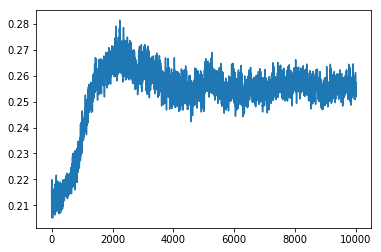

In [40]:
plt.plot(history.history['val_loss'])

In [41]:
eval_df = x_test

In [42]:
eval_df['pred'] = model.predict(x_test_t, batch_size=batch_size)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
eval_df['real'] = y_test

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
eval_df.head()

,close,open,high,low,ret,ma5,ma20,pred,real
Date,,,,,,,,,
2015-01-01,0.072168,-0.606668,-0.733170,-0.036006,0.072028,-0.614354,-0.674753,-0.602247,-0.781815
2015-01-02,-0.866480,0.071231,0.051292,-0.884043,-0.870585,-0.781815,-0.689133,-0.782573,-0.868014
2015-01-05,-0.717638,-0.865147,-0.901290,-0.943284,-0.726306,-0.868014,-0.815584,-0.861551,-0.925877
2015-01-06,-0.530429,-0.713463,-0.510701,0.008746,-0.541074,-0.925877,-0.894609,-0.861335,-0.918841
2015-01-07,-0.575525,-0.482139,-0.770422,-0.838145,-0.588204,-0.918841,-0.947133,-0.854948,-0.956216


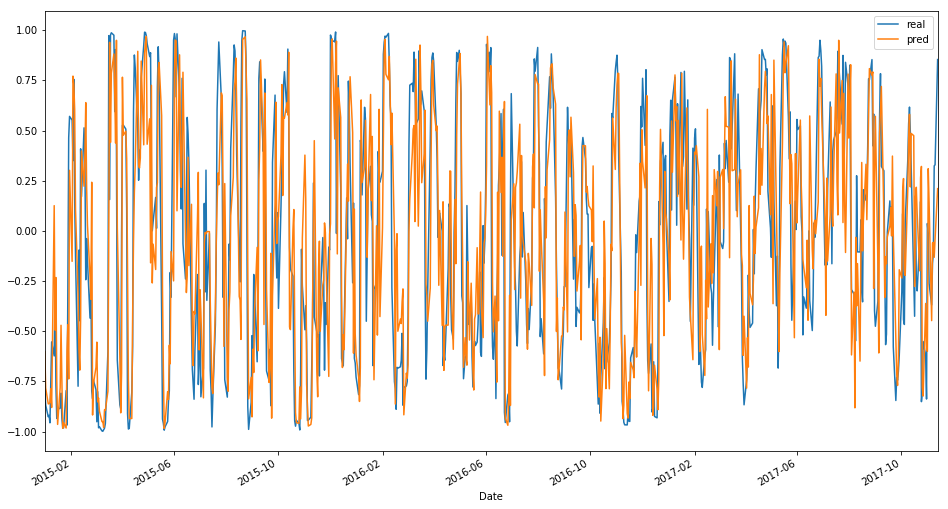

In [45]:
eval_df.loc[:,['real','pred']].plot(figsize=(16,9))

In [46]:
f.R_squared(eval_df.pred,eval_df.real)

0.52222750166020315

In [47]:
final_df = eval_df[['close', 'ret', 'ma5', 'real', 'pred']].copy()

In [48]:
for col in final_df.columns:
    final_df[col] = f.unscale(final_df[col])

In [49]:
final_df.head()

,close,ret,ma5,real,pred
Date,,,,,
2015-01-01,0.072293,0.072153,-0.715885,-1.050023,-0.696665
2015-01-02,-1.318779,-1.335490,-1.050023,-1.324967,-1.051975
2015-01-05,-0.902758,-0.920865,-1.324967,-1.628703,-1.299330
2015-01-06,-0.590741,-0.605673,-1.628703,-1.581536,-1.298494
2015-01-07,-0.655745,-0.674915,-1.581536,-1.899745,-1.274261


In [50]:
f.R_squared(final_df.pred,final_df.real)


0.55422333828819292